# Customer segmentation (clustering)
## Hotel client data
### This notebook uses the *Case1_HotelCustomerSegmentation.csv* dataset

Master Degree Program in Data Science and Advanced Analytics

**Group C** </br>
Carolina Caldeira 20230440</br>
Gonçalo Caldeirinha 20230469</br>
Madalena Figueirinhas 20230436</br>
Martyna Kmiecik 20230452</br>
Alina Metzger 20230998</br>

### Dataset description

Dataset related to bookings made for Hotel H, a hotel located in Lisbon, Portugal, member of the independent hotel chain C. The hotel uses a hospitality standard market segmentation based on the origin of the customer. However, today is well-known that this strategy is not useful for the hotel marketing department. The following notebook aims to optimize this segmentation based on the different characteristics of the clients.

**client data:**
- **ID**: customer ID (numerical)
- **Nationality**: Nationality of the customer in ISO 3166-1 (Alpha 3) format (categorical)
- **Age**: The age of the customer (numerical)
- **DaysSinceCreation**: Number of elapsed days since the customeeer was created (numerical)
- **NameHash**: Hash of the customer's name (categorical)
- **DocIDHash**: Hash of the customer’s personal document identification number (usually a passport or ID card)(categorical)

**related with the booking:**
- **AverageLeadTime**: Average number of days before arrival date the customer makes bookings (numerical)
- **LodgingRevenue**: Total amount of lodging revenue paid by the customer so far (numerical) 
- **OtherRevenue**: Total amount of other revenue (e.g., food & beverage, spa, etc.) paid by the customer so far (numerical)
- **BookingsCanceled**: Number of bookings the customer made but subsequently canceled (numerical)
- **BookingsNoShowed**:  Number of bookings the customer made but subsequently made a "no-show" (numerical)
- **BookingsCheckedin**:  Number of bookings the customer made, which actually ended up staying (numerical)
- **PersonNights**: Total person/nights the customer has stayed at the hotel so far. Persons/Nights are the sum of Adults and Children in each booking, multiplied by the number of Nights (Length-of-stay) of the booking (numerical)
- **RoomNights**: Total of room/nights the customer has stayed at the hotel so far. Room/Nights are the multiplication of the number of rooms of each booking by the the number of Nights (Length-ofstay) of the booking (numerical)

**related with the booking purpose and where it was made:**
- **DistributionChannel**: Distribution channel normally used by the customer to make bookings at the hotel (categorical)
- **MarketSegment**: Current market segment of the customer (categorical)

**related with special requests:**
- **SRHighFloor**: Indication if the customer usually asks for a room in a higher floor (categorical - 0: No, 1: Yes)
- **SRLowFloor**: Indication if the customer usually asks for a room in a lower floor (categorical - 0: No, 1: Yes)
- **SRAccessibleRoom**: Indication if the customer usually asks for an accessible room (categorical - 0: No, 1: Yes)
- **SRMediumFloor**: Indication if the customer usually asks for a room in a middle floor (categorical - 0: No, 1: Yes)
- **SRBathtub**: Indication if the customer usually asks for a room with a bathtub (categorical - 0: No, 1: Yes)
- **SRShower**: Indication if the customer usually asks for a room with a shower (categorical - 0: No, 1: Yes)
- **SRCrib**: Indication if the customer usually asks for a crib (categorical - 0: No, 1: Yes)
- **SRKingSizeBed**: Indication if the customer usually asks for a room with a king size bed (categorical - 0: No, 1: Yes)
- **SRTwinBed**: Indication if the customer usually asks for a room with a twin bed (categorical - 0: No, 1: Yes)
- **SRNearElevator**: Indication if the customer usually asks for a room near the elevator (categorical - 0: No, 1: Yes)
- **SRAwayFromElevator**: Indication if the customer usually asks for a room away from the elevator (categorical - 0: No, 1: Yes)
- **SRNoAlcoholInMiniBar**: Indication if the customer usually asks for a room with no alcohol in the mini bar (categorical - 0: No, 1: Yes)
- **SRQuietRoom**: Indication if the customer usually asks for a room away from the noise (categorical - 0: No, 1: Yes)


NOTE: All time-based columns (e.g., Age or DaysSinceCreation) were calculated at the dataset extraction date.

## Initial setup and modules/packages loading

In [135]:
# Packages
import os
import numpy as np
import pandas as pd
#!pip install matplotlib
#!pip install seaborn
#!pip install joypy
#!pip install category_encoders
#!pip install yellowbrick
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

from math import ceil

In [136]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [137]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

## Importing Data

In [138]:
# Load data 
ds = pd.read_csv('Case1_HotelCustomerSegmentation.csv', sep=";")

In [139]:
# Display all columns in the dataset
pd.set_option('display.max_columns', None)

# Display top 5 rows
ds.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,0,2,6,4,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,0,1,10,5,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,0,1,10,5,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Exploration

In [140]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

**Info:**
- **Float**: Age, LodgingRevenue, OtherRevenue (Age should be Int also?)
- **Object**: Nationality, NameHash, DocIDHash, DistributionChannel, MarketSegment
- **Int**: ID, DaysSinceCreation, AverageLeadTime, Booking Behavior, PersonsNights, RoomNights, Service Rquetests

In [141]:
#Checking number of rows and columns in the dataset
print(ds.shape)

(111733, 29)


In [142]:
ds['ID'].nunique()
#ID has only unique values and no missing values - possible index

111733

In [143]:
#Checking if there is any row having only missing values
ds_cleaned = ds.dropna(how='all')
print(ds_cleaned.shape, ds.shape)

(111733, 29) (111733, 29)


In [144]:
# Summary statistics for all variables
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,111733.0,NaN,NaN,NaN,55867.0,32254.683151,1.0,27934.0,55867.0,83800.0,111733.0
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
NameHash,111733,107584,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DocIDHash,110732,103480,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0


- Age has a min negative value -10 and a max value of 123
- **Nationality** has 199 categories. This can indicate issues in distribution, such as some categories win many observations and others with only a few observations. **MarketSegment** and **DistributionChannel** also have a high number of categories. 

In [145]:
# Check missing values
print(ds.isnull().sum())

ID                         0
Nationality                0
Age                     4172
DaysSinceCreation          0
NameHash                   0
DocIDHash               1001
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


- Age and DocIDHash present missing values.

In [146]:
# Setting the 'ID' column as the index
ds = ds.set_index('ID')

In [147]:
# Check duplicate records
print(ds.duplicated().value_counts())

False    111622
True        111
Name: count, dtype: int64


In [148]:
ds[ds.duplicated(keep=False)].head(10)

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
594,ROU,38.0,1365,0x71AD7B2E07CAD82195B968B7CDD7961EC953760899B5...,0x9CD129744684370C750190DB02D767653BB96C8119B3...,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
595,ROU,38.0,1365,0x71AD7B2E07CAD82195B968B7CDD7961EC953760899B5...,0x9CD129744684370C750190DB02D767653BB96C8119B3...,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
701,BRA,26.0,1359,0x74E713DA50B1E31F73E557BE97E695F2F91DF974EFCD...,0xB4945744933DB61354AEE815E46203B3BEA62AA339A0...,0,0.0,0.0,0,0,0,0,0,Corporate,Groups,0,0,0,0,0,0,0,0,0,0,0,0,0
702,BRA,26.0,1359,0x74E713DA50B1E31F73E557BE97E695F2F91DF974EFCD...,0xB4945744933DB61354AEE815E46203B3BEA62AA339A0...,0,0.0,0.0,0,0,0,0,0,Corporate,Groups,0,0,0,0,0,0,0,0,0,0,0,0,0
1110,PRT,NaN,1345,0x517974F81AFEBB5A7D7364B258EF7E3536190C01850F...,NaN,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
1111,PRT,NaN,1345,0x517974F81AFEBB5A7D7364B258EF7E3536190C01850F...,NaN,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
1377,PRT,NaN,1340,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,NaN,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
1391,PRT,NaN,1340,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,NaN,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
1403,PRT,NaN,1340,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,NaN,0,0.0,0.0,0,0,0,0,0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
ds.drop_duplicates(inplace=True) # Droping rows that are the same 

In [150]:
# Count unique and duplicated entries in the 'NameHash' column of the dataframe
ds['NameHash'].duplicated().value_counts()

NameHash
False    107584
True       4038
Name: count, dtype: int64

In [151]:
# Count unique and duplicated entries in the 'DocIDHash' column of the dataframe
ds['DocIDHash'].duplicated().value_counts()

DocIDHash
False    103481
True       8141
Name: count, dtype: int64

In [152]:
# Count unique and duplicated entries in the 'DocIDHash' column, excluding NA values, to determine the number of non-duplicated and duplicated values
ds['DocIDHash'].dropna().duplicated().value_counts()

DocIDHash
False    103480
True       7210
Name: count, dtype: int64

In [153]:
# Count ocurrences for each unique value in each feature
for column in ds.columns:
    print(ds[column].value_counts())

Nationality
FRA    16507
DEU    14805
PRT    14020
GBR    11459
ESP     6123
       ...  
BHS        1
TMP        1
TZA        1
PNG        1
BDI        1
Name: count, Length: 199, dtype: int64
Age
51.0     2579
52.0     2559
55.0     2557
50.0     2502
54.0     2492
         ... 
115.0       2
123.0       1
97.0        1
110.0       1
95.0        1
Name: count, Length: 106, dtype: int64
DaysSinceCreation
502     298
522     247
108     234
312     234
137     232
       ... 
1367      5
1363      4
1370      4
763       3
1209      1
Name: count, Length: 1349, dtype: int64
NameHash
0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51EF134B078B9D61A8CC4A    43
0xF1465EC9E2D0027094B7C3D72772A862A635E461FFFC9AA009C2BD78D31BBB63    22
0x8DF2AF984365949E7F4EAB2EBA9BF9CA8DF106B5F2A960AD7D9A7FB4EC61D02F    21
0xD32FF3D74C193EF22762853A9F3DFAE05172A9537CCA78A8D519372EB35BB910    18
0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D8787F8C7A413529295FD50    15
                                             

In [154]:
# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

In [155]:
# Create a list with the categorical features
_cat = ds.drop(columns=ds[numerical])
_cat_list = ds.drop(columns=ds[numerical]).columns.to_list()
_cat_list

['Nationality',
 'NameHash',
 'DocIDHash',
 'DistributionChannel',
 'MarketSegment']

In [156]:
# Exploration of categorical variables: cross table of job and education
table1 = pd.crosstab(index=ds['MarketSegment'], columns=ds['DistributionChannel'])
table1

DistributionChannel,Corporate,Direct,GDS Systems,Travel Agent/Operator
MarketSegment,,,,
Aviation,281,0,0,7
Complementary,19,508,0,128
Corporate,2204,51,2,674
Direct,13,15965,7,373
Groups,480,171,5,10794
Other,37,151,677,62728
Travel Agent/Operator,99,30,5,16213


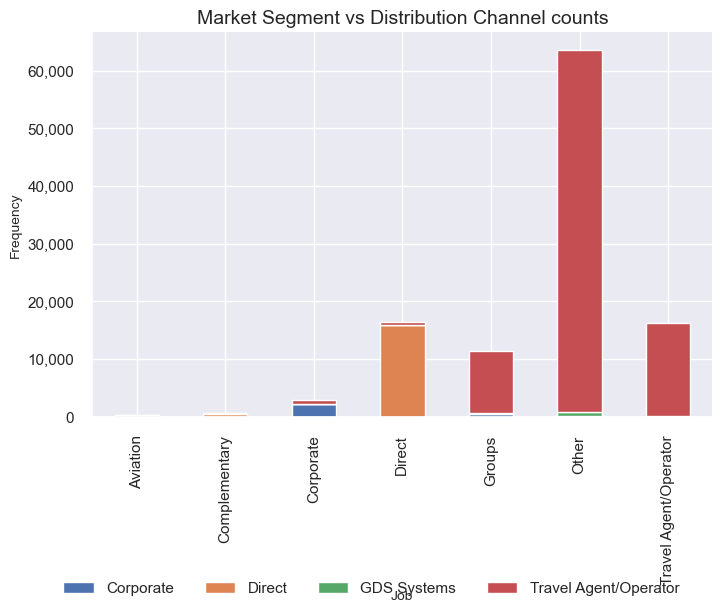

In [157]:
# Draw
fig, ax = plt.subplots(figsize=(8,5))
table1.plot(kind="bar", 
            ax=ax,
            stacked=True)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Market Segment vs Distribution Channel counts", fontsize=plots_Title_fontSize)
plt.xlabel("Job")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower center', 
          ncol=4, bbox_to_anchor=(0.45, -0.5), frameon=False)

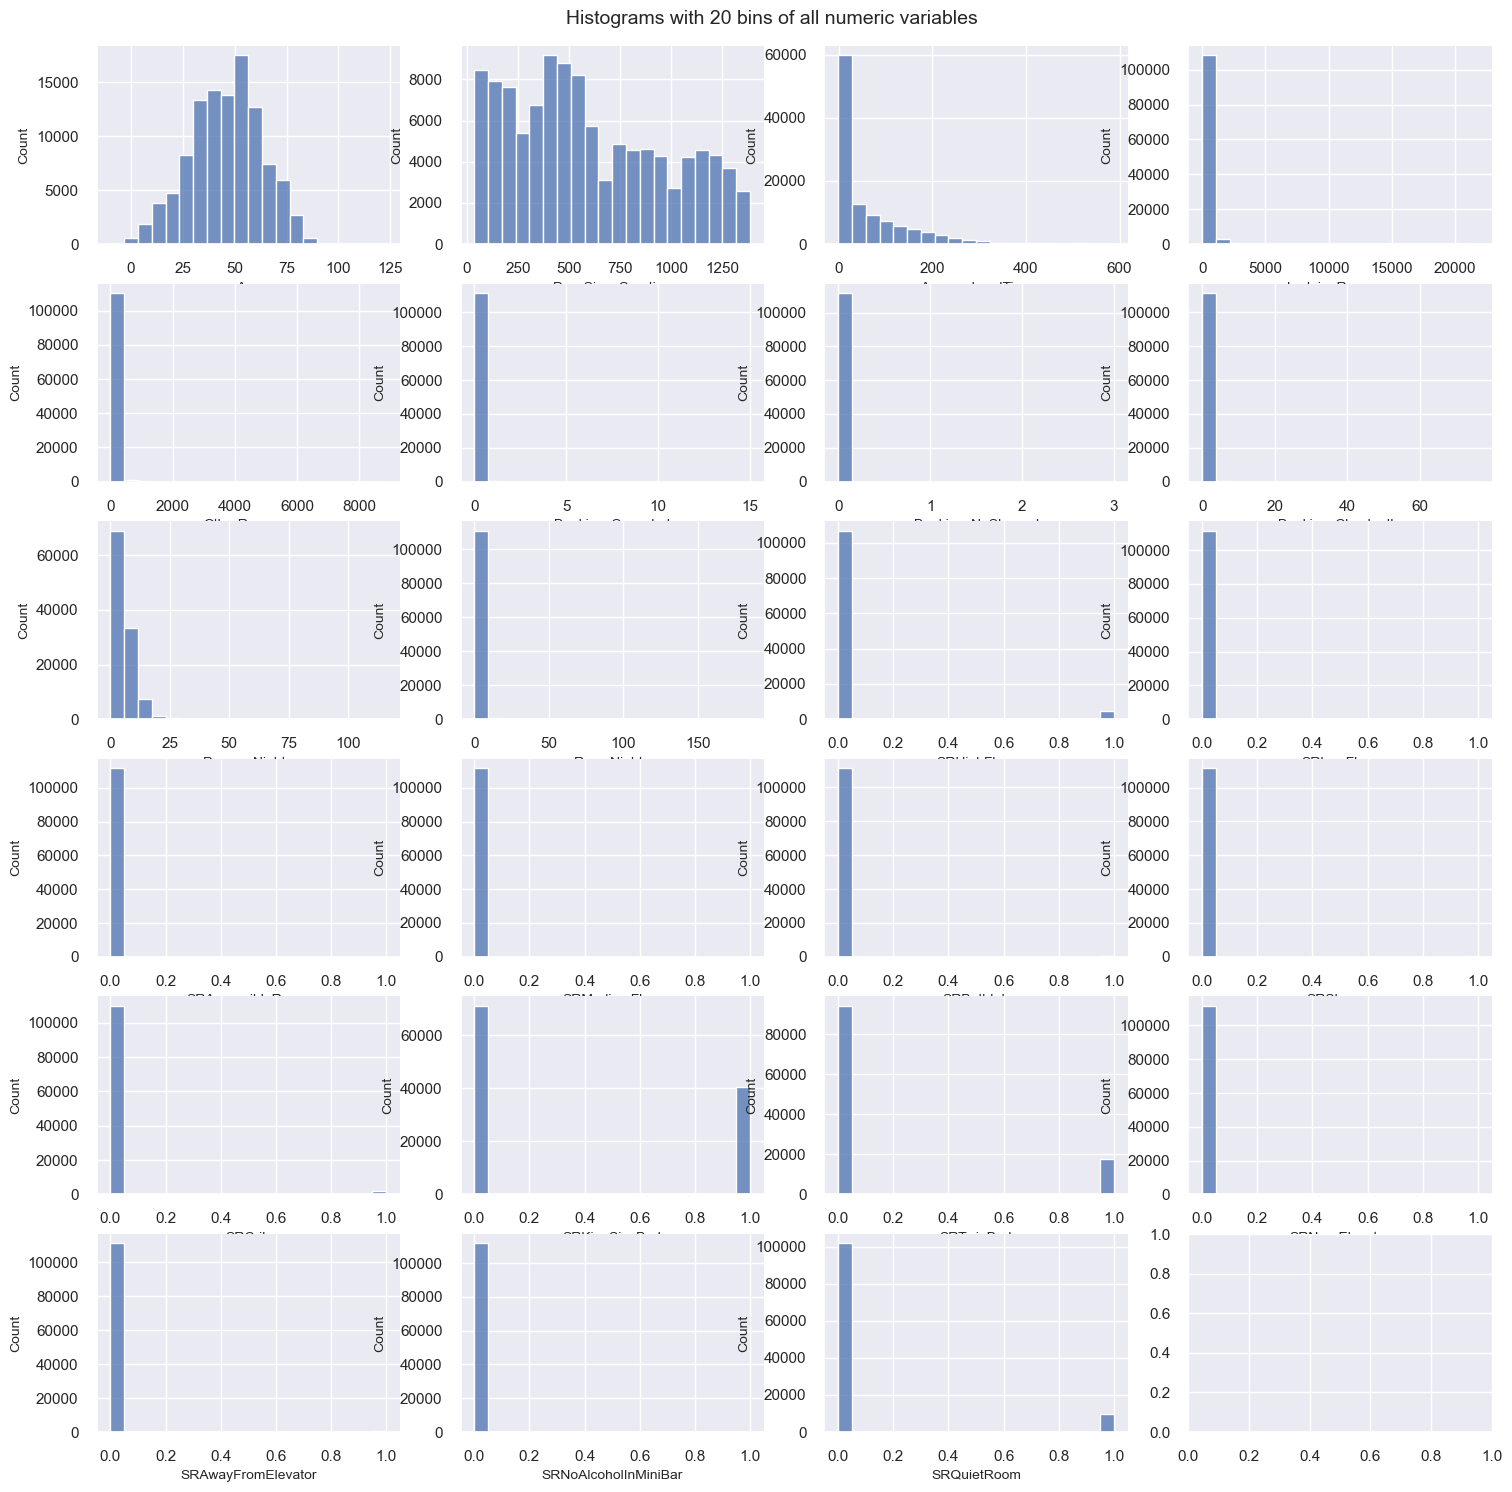

In [158]:
# HISTOGRAM (ALL NUMERIC VARIABLES)
# Draw
fig, ax = plt.subplots(6, 4, figsize=(18,18))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
title = fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize);
title.set_position([0.5, 0.9]) 

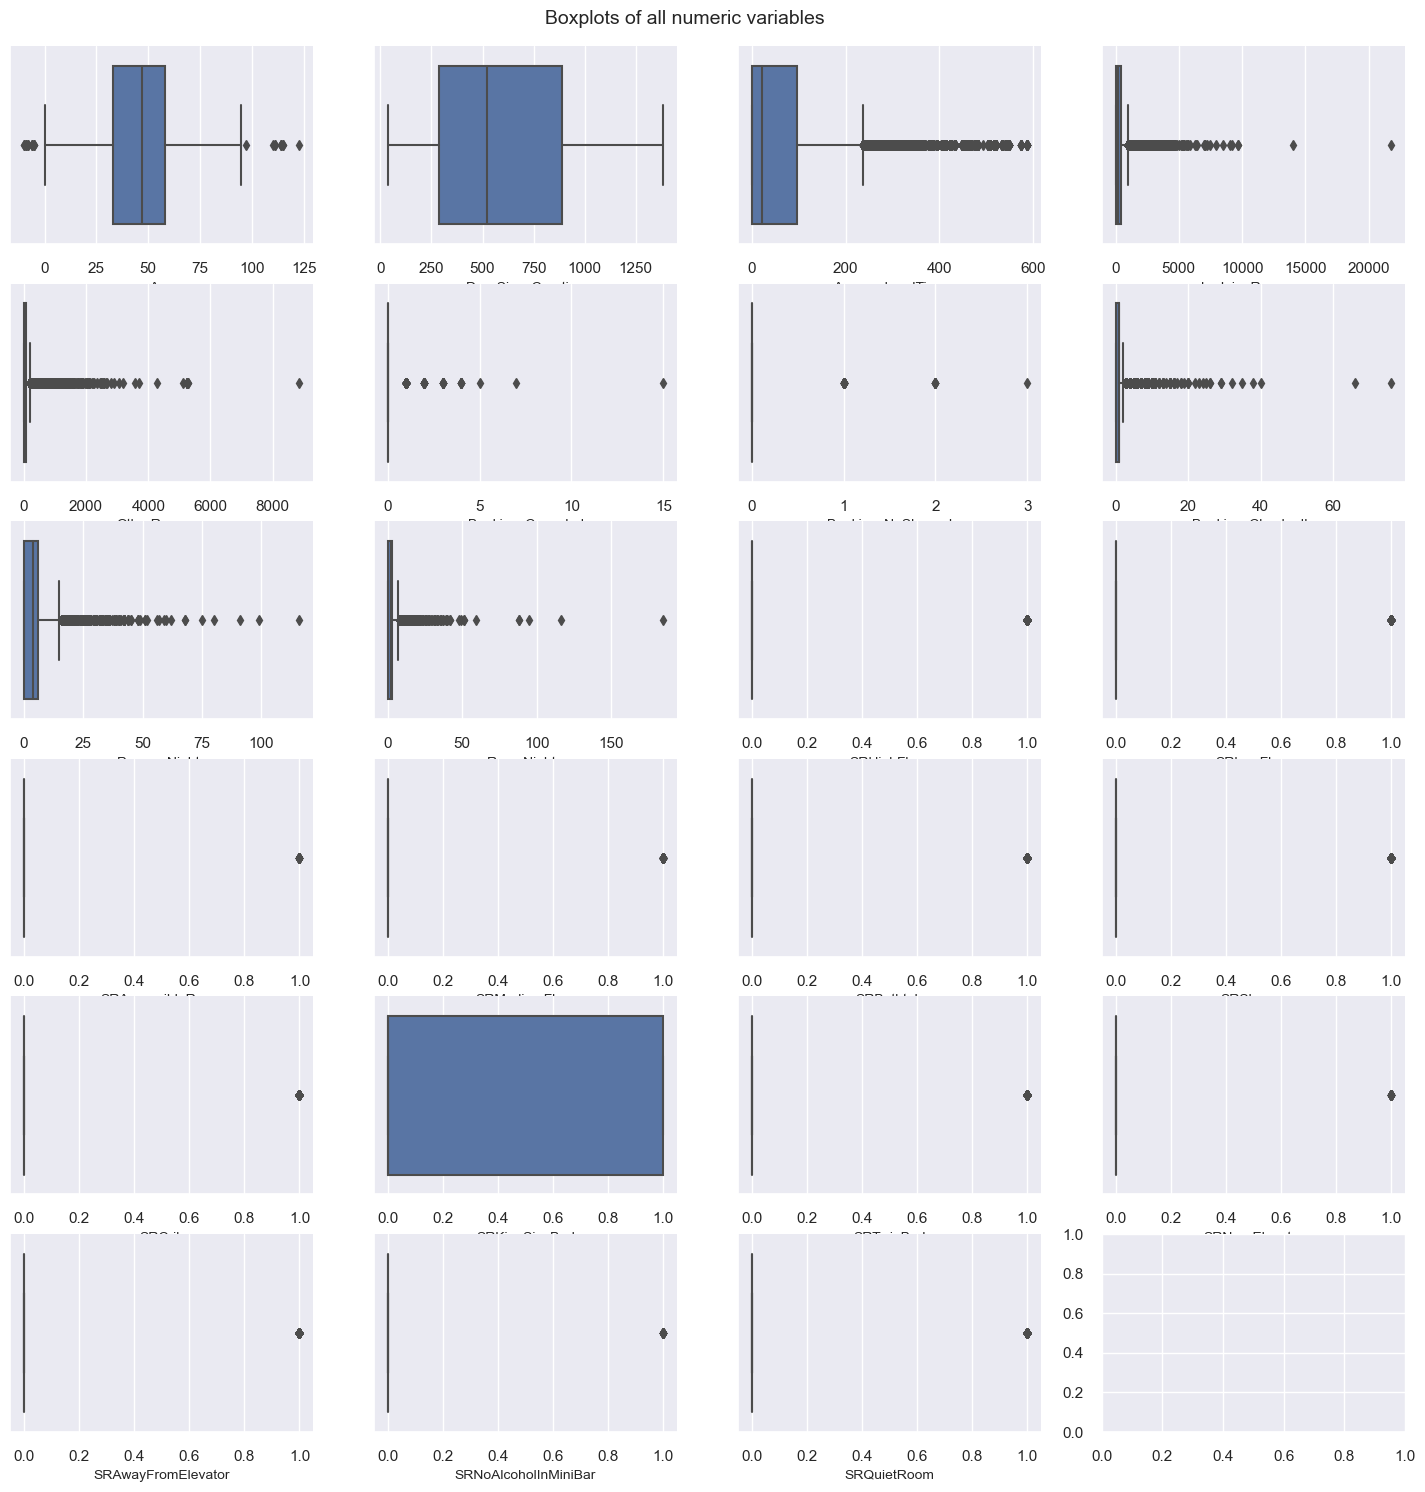

In [159]:
# BOXPLOT (ALL NUMERIC VARIABLES)

# Draw
fig, ax = plt.subplots(6, 4, figsize=(18,18))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.boxplot(data=ds,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
title = fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize);
title.set_position([0.5, 0.9]) 

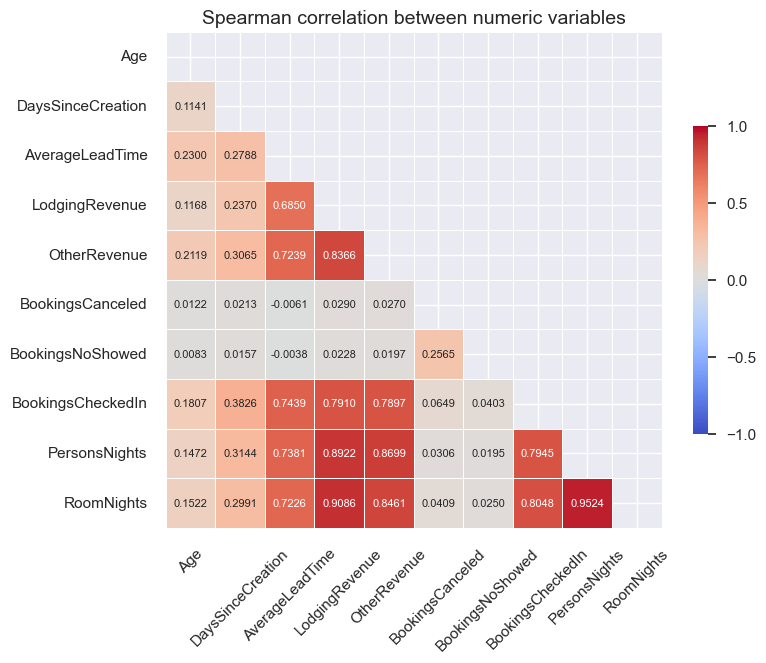

In [160]:
# CORRELATION 
_num = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 
                      'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights']
                   
# Create correlation matrix
corr = ds[_num].corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(8, 10))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Data preparation

**Previows insides**

`Info:`
- **Float**: Age, LodgingRevenue, OtherRevenue (Age não deveria ser Int?)
- **Object**: Nationality, NameHash, DocIDHash, DistributionChannel, MarketSegment
- **Int**: ID, DaysSinceCreation, AverageLeadTime, Booking Behavior, PersonsNights, RoomNights, Service Rquetests

`Summary statistics shows:`
- Age and DocIDHash present missing values.
- Age has a min negative value -10 and a max value of 123
- **Nationality** has 199 categories. This can indicate issues in distribution, such as some categories win many observations and others with only a few observations. **MarketSegment** and **DistributionChannel** also have a high number of categories. 


In [161]:
# Create a modeling dataset from the original dataset
ds_prep = ds.copy()

In [162]:
# Checking null values in DocIDHash since it should be unique
ds_prep['DocIDHash'].isnull().sum()

932

In [163]:
# Rows where 'DocIDHash' is filled with the specified value may indicate some hotel operations
operations = ds_prep[ds_prep['DocIDHash'] == "0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855"]

In [164]:
# Removing rows where 'DocIDHash' is filled with the specified value indicating some hotel operations - not customers
ds_prep = ds_prep[ds_prep['DocIDHash'] != "0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855"]

DocIDHash = "0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B934CA495991B7852B855" is the one with the most amount of counts, and so it was assumed the be a code inserted by the Hotel when they are doing some hotel operations (for instance refunds etc.)
We will remove them.

In [165]:
#We are keeping people who never checked in a separate dataframe as they were never really present at the hotel
NotCustomers = ds_prep[ds_prep['BookingsCheckedIn'] == 0]

In [166]:
#People who never checked in are no use for us as we don't have their proper information
ds_prep = ds_prep[ds_prep['BookingsCheckedIn'] != 0]

In [167]:
ds_prep.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,75366.0,48.056962,15.192701,-10.0,37.0,48.0,58.0,115.00
DaysSinceCreation,75625.0,681.758902,375.204541,36.0,370.0,699.0,997.0,1385.00
AverageLeadTime,75625.0,87.189673,89.928197,-1.0,17.0,58.0,133.0,588.00
LodgingRevenue,75625.0,408.144700,397.331832,0.0,189.0,312.4,488.4,21781.00
OtherRevenue,75625.0,92.584457,137.753516,0.0,28.0,58.5,115.0,8859.25
BookingsCanceled,75625.0,0.003041,0.096024,0.0,0.0,0.0,0.0,15.00
BookingsNoShowed,75625.0,0.000793,0.032515,0.0,0.0,0.0,0.0,3.00
BookingsCheckedIn,75625.0,1.049177,0.663400,1.0,1.0,1.0,1.0,76.00
PersonsNights,75625.0,6.214969,4.394511,0.0,3.0,6.0,8.0,116.00
RoomNights,75625.0,3.159947,2.151129,1.0,2.0,3.0,4.0,185.00


In [168]:
# Correcting the negative values for Age
ds_prep.loc[ds_prep['Age'] < 0, 'Age'] = np.nan

### Filling Missing Values

In [169]:
print(ds_prep.isna().sum())

Nationality               0
Age                     271
DaysSinceCreation         0
NameHash                  0
DocIDHash                 4
AverageLeadTime           0
LodgingRevenue            0
OtherRevenue              0
BookingsCanceled          0
BookingsNoShowed          0
BookingsCheckedIn         0
PersonsNights             0
RoomNights                0
DistributionChannel       0
MarketSegment             0
SRHighFloor               0
SRLowFloor                0
SRAccessibleRoom          0
SRMediumFloor             0
SRBathtub                 0
SRShower                  0
SRCrib                    0
SRKingSizeBed             0
SRTwinBed                 0
SRNearElevator            0
SRAwayFromElevator        0
SRNoAlcoholInMiniBar      0
SRQuietRoom               0
dtype: int64


In [170]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors

# Scaling the data to impute missing values for metric features with KNN imputer, inversing the scaling afterwards
# n_neighbors=10 because the dataset is big
# RobustScaler - robust to outliers

ds_neighbors = ds_prep.copy()
scaler = RobustScaler()
imputer = KNNImputer(n_neighbors=10, weights="uniform")

ds_neighbors[_num] = scaler.fit_transform(ds_neighbors[_num])  
ds_neighbors[_num] = imputer.fit_transform(ds_neighbors[_num])

inverted_data = scaler.inverse_transform(ds_neighbors[_num])
ds_neighbors[_num] = inverted_data

print(ds_neighbors.isna().sum())

Nationality             0
Age                     0
DaysSinceCreation       0
NameHash                0
DocIDHash               4
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
DistributionChannel     0
MarketSegment           0
SRHighFloor             0
SRLowFloor              0
SRAccessibleRoom        0
SRMediumFloor           0
SRBathtub               0
SRShower                0
SRCrib                  0
SRKingSizeBed           0
SRTwinBed               0
SRNearElevator          0
SRAwayFromElevator      0
SRNoAlcoholInMiniBar    0
SRQuietRoom             0
dtype: int64


In [171]:
# Looking at the 4 rows with missing values in DocIDHash
ds_neighbors[pd.isna(ds_neighbors['DocIDHash'])]

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59,PRT,46.3,1385.0,0x51764F97FD9E3426C98D7DFEFE3A2A2D3C724089ECFB...,NaN,0.0,0.0,2.00,0.0,0.0,2.0,2.0,2.0,Direct,Complementary,0,0,0,0,0,0,0,0,0,0,0,0,0
945,PRT,48.6,1350.0,0xCDA04881493C308AD327EC8BD0CF014DD514E90F48B9...,NaN,0.0,54.0,42.00,0.0,0.0,2.0,6.0,4.0,Direct,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0
20497,PRT,48.1,1020.0,0xC6E889DC7511C94DB21A4BA17711C5AFB56C18B9AB9B...,NaN,9.0,0.0,39.00,0.0,0.0,2.0,6.0,3.0,Direct,Complementary,0,0,0,0,0,0,0,1,0,0,0,0,0
35430,PRT,47.2,780.0,0xAAD113AA0A812CB11CF085F14B8AB57A1DA6F433D338...,NaN,4.0,1852.0,361.92,0.0,0.0,2.0,6.0,4.0,Direct,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0


In [172]:
nan_rows = ds_neighbors[pd.isna(ds_neighbors['DocIDHash'])]
nan_rows['NameHash'].value_counts()

NameHash
0x51764F97FD9E3426C98D7DFEFE3A2A2D3C724089ECFB81FF8D640357A3E53D56    1
0xCDA04881493C308AD327EC8BD0CF014DD514E90F48B9B4F8EBF9E335CF9476D3    1
0xC6E889DC7511C94DB21A4BA17711C5AFB56C18B9AB9B76162BD4717A12C896E8    1
0xAAD113AA0A812CB11CF085F14B8AB57A1DA6F433D338BC466F3F318862C19093    1
Name: count, dtype: int64

In [173]:
ds_prep[ds_prep['NameHash'] == '0x51764F97FD9E3426C98D7DFEFE3A2A2D3C724089ECFB81FF8D640357A3E53D56']

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59,PRT,NaN,1385,0x51764F97FD9E3426C98D7DFEFE3A2A2D3C724089ECFB...,NaN,0,0.0,2.0,0,0,2,2,2,Direct,Complementary,0,0,0,0,0,0,0,0,0,0,0,0,0


In [174]:
ds_prep[ds_prep['NameHash'] == '0xCDA04881493C308AD327EC8BD0CF014DD514E90F48B9B4F8EBF9E335CF9476D3']

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
945,PRT,NaN,1350,0xCDA04881493C308AD327EC8BD0CF014DD514E90F48B9...,NaN,0,54.0,42.0,0,0,2,6,4,Direct,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0


In [175]:
ds_prep[ds_prep['NameHash'] == '0xC6E889DC7511C94DB21A4BA17711C5AFB56C18B9AB9B76162BD4717A12C896E8']

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20497,PRT,NaN,1020,0xC6E889DC7511C94DB21A4BA17711C5AFB56C18B9AB9B...,NaN,9,0.0,39.0,0,0,2,6,3,Direct,Complementary,0,0,0,0,0,0,0,1,0,0,0,0,0


In [176]:
ds_prep[ds_prep['NameHash'] == '0xAAD113AA0A812CB11CF085F14B8AB57A1DA6F433D338BC466F3F318862C19093']

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
35430,PRT,NaN,780,0xAAD113AA0A812CB11CF085F14B8AB57A1DA6F433D338...,NaN,4,1852.0,361.92,0,0,2,6,4,Direct,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0


- By deleting people who never checked in we removed many people with missing ID value and age missing values
- These 4 people do not have the id and they are not related to other people in our dataset so we remove them, because we cannot be sure about their real information - they do not add value (moreover it is an insignificant number of customers)

In [177]:
ds_neighbors = ds_neighbors.dropna(subset=['DocIDHash'])

In [178]:
ds_prep = ds_neighbors.copy()

In [179]:
# Changing the datatypes of each variable
ds_prep.Age = ds_prep.Age.astype('int32')

for col in ds_prep.columns:
    if ds_prep[col].dtype == 'int64':
        ds_prep[col] = ds_prep[col].astype('int32')
        
for col in ds_prep.columns:
    if ds_prep[col].dtype == 'float64':
        ds_prep[col] = ds_prep[col].astype('float32')

### DocIDHash Inconsistencies (1st fase)
- In this fase we will deal with the repeated values for DocIDHash except the most recurrent one

In [180]:
# Calculate counts
counts = ds_prep['DocIDHash'].value_counts()

# Identify DocIDHash values that meet the criteria
valid_hashes = counts[(counts > 1)].index

# Filter the original DataFrame
filtered_ds = ds_prep[ds_prep['DocIDHash'].isin(valid_hashes)]

In [181]:
filtered_ds['DocIDHash'].value_counts()

DocIDHash
0xA486FBACF4B4E5537B026743E3FDFE571D716839E758236F42950A61FE6B922B    31
0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECECF45D6BBDBAF9A274FF52    24
0x469CF1F9CF8C790FFA5AD3F484F2938CBEFF6435BCFD734F687EC6D1E968F076    14
0x2A14D03A4827C67E0D39408F103DB417AD496DCE6158F8309E6281185C042003    14
0x3856085146F7BC27BD07BFC4CA1991ED4E65E179D7BDB7DBBA7E32620809C799    12
                                                                      ..
0x91504C027182309BDE4B84FEDCB547E820B6619010AB37059CBBB3DF40479D12     2
0xA508EDBFE269E231546629F11587FA2AAD4DE4851A31975B6730410041433248     2
0x0F2398A353B296AF95261B8778FD6922D7544BFB224DEC30A93017331E14BEAF     2
0xD275B2C963622B954620E3BD6C4FFF3874CCB5DD444CBB34B5CCA032BDDBAA34     2
0x5C663955C031CD8956B82C3105C2AF0D8DDA97677FC3BC9DBBC28C060555C80C     2
Name: count, Length: 2132, dtype: int64

In [182]:
ds_prep[ds_prep['DocIDHash'] == '0xA486FBACF4B4E5537B026743E3FDFE571D716839E758236F42950A61FE6B922B']

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12953,PRT,51,1147.0,0xD345B7964D8B1D2438F4F54BC14AEC9C5261AC3C2CB6...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,21.0,6991.000000,957.000000,0.0,2.0,40.0,116.0,116.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
15838,PRT,51,1105.0,0x1A2DCD85060585D37DE6D8B246DD54B90A427F58BD74...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,5.0,652.000000,78.000000,1.0,0.0,6.0,11.0,11.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
16388,PRT,51,1098.0,0x1A2DCD85060585D37DE6D8B246DD54B90A427F58BD74...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,6.0,1803.000000,191.000000,1.0,0.0,10.0,22.0,22.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
33692,PRT,51,806.0,0xC23921914E37630222F29FEAC44CAE7FE25E6B10E9F9...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,29.0,356.000000,44.000000,0.0,0.0,2.0,6.0,6.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
33701,PRT,51,806.0,0xB96591E35F443A512E68447228F63946D4FB948E7E85...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,2.0,120.000000,12.000000,0.0,1.0,1.0,2.0,2.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
33826,PRT,51,804.0,0x6C5F83CA37178B8711D808B3132F2CAF87D35A8C1D4E...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,4.0,372.100006,59.900002,0.0,0.0,3.0,8.0,6.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
34081,PRT,51,800.0,0xB96591E35F443A512E68447228F63946D4FB948E7E85...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,4.0,413.000000,51.000000,1.0,0.0,7.0,7.0,7.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
34183,PRT,51,798.0,0x6C5F83CA37178B8711D808B3132F2CAF87D35A8C1D4E...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,7.0,295.000000,47.400002,0.0,0.0,2.0,5.0,5.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
41476,PRT,51,693.0,0x8DF2AF984365949E7F4EAB2EBA9BF9CA8DF106B5F2A9...,0xA486FBACF4B4E5537B026743E3FDFE571D716839E758...,12.0,1009.000000,134.000000,2.0,0.0,7.0,15.0,16.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0


In [183]:
ds_prep[ds_prep['DocIDHash'] == '0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECECF45D6BBDBAF9A274FF52']

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2160,PRT,48,1323.0,0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D87...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,20.0,8493.650391,2587.5,3.0,1.0,66.0,75.0,95.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
22852,PRT,48,966.0,0x92500586215142EBDA0057D3A792411F0D2A3E2A8455...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,1.0,74.000000,7.0,0.0,0.0,1.0,1.0,1.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
22854,PRT,48,966.0,0xD79CBB59C811C34D1228585CEAD9E6CD26E5BA342E02...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,22.0,1569.000000,338.0,4.0,1.0,15.0,18.0,18.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
22855,PRT,48,966.0,0x968E52B041E8F43DE2E14F21093DEF5439EB5251FE79...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,3.0,758.000000,83.0,0.0,0.0,7.0,9.0,9.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
26929,PRT,48,903.0,0x7FED68C6755707148189209F36950A10F2E18267C2A4...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,25.0,267.000000,30.0,0.0,0.0,2.0,3.0,3.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
42599,PRT,48,665.0,0xD79CBB59C811C34D1228585CEAD9E6CD26E5BA342E02...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,43.0,968.000000,183.0,0.0,0.0,9.0,11.0,11.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
44884,PRT,48,623.0,0xD79CBB59C811C34D1228585CEAD9E6CD26E5BA342E02...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,28.0,1551.000000,252.0,2.0,0.0,16.0,18.0,18.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
47383,PRT,48,595.0,0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D87...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,24.0,900.000000,110.0,0.0,0.0,7.0,10.0,10.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0
48016,PRT,48,588.0,0x312DAA3B97FDE8F21F4FDDDA880E11C9D049036FFF11...,0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECEC...,6.0,534.000000,66.0,2.0,0.0,6.0,6.0,6.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0


In [184]:
#The IDs have different names even though they use the same ID
ds_prep[ds_prep['DocIDHash'] == '0xA486FBACF4B4E5537B026743E3FDFE571D716839E758236F42950A61FE6B922B']['NameHash'].value_counts()

NameHash
0x8DF2AF984365949E7F4EAB2EBA9BF9CA8DF106B5F2A960AD7D9A7FB4EC61D02F    20
0x1A2DCD85060585D37DE6D8B246DD54B90A427F58BD74B62BAFC8296B81AA9C2F     2
0xB96591E35F443A512E68447228F63946D4FB948E7E85689C45227BC37950AA67     2
0x6C5F83CA37178B8711D808B3132F2CAF87D35A8C1D4E4EDB08777A38DA28315F     2
0xD345B7964D8B1D2438F4F54BC14AEC9C5261AC3C2CB6C51A821B8E6563BB1C0B     1
0xC23921914E37630222F29FEAC44CAE7FE25E6B10E9F9B392FD29F44F2391DF68     1
0x6232B6453BD9CE4755167DE6104ACCFB25891A3F238327884347F3B9C7339F38     1
0xEFD68666273996086DCF6E1EBF72CFE21DB5805DD6FBD1131F27DCFD99881948     1
0xCFC591C74C0EF4379B8AA72A483941CAF13A7B834421E315B1A2FCAE7EEE412D     1
Name: count, dtype: int64

In [185]:
ds_prep[ds_prep['DocIDHash'] == '0x2B17E9D2CCEF2EA0FE752EE345BEDFB06741FFC8ECECF45D6BBDBAF9A274FF52']['NameHash'].value_counts()

NameHash
0xFB64B4B6AB53A6A549A620009CA24A1C3A668A460D8787F8C7A413529295FD50    15
0xD79CBB59C811C34D1228585CEAD9E6CD26E5BA342E023F6458B7B614F9FCA344     4
0x968E52B041E8F43DE2E14F21093DEF5439EB5251FE7950DF21ED2BE1A069934A     2
0x92500586215142EBDA0057D3A792411F0D2A3E2A8455E06168A449EEE4128159     1
0x7FED68C6755707148189209F36950A10F2E18267C2A4BA2AC8CF8E8DB2A9CF6E     1
0x312DAA3B97FDE8F21F4FDDDA880E11C9D049036FFF113F78B2B823090C1F7BEC     1
Name: count, dtype: int64

In [186]:
# Function to apply the mode to columns with categorical data, returning the most frequent value and the mode(x) otherwise,
# if the rows don't have the mode

def moda(x):
    mode_val = x.mode()
    if not mode_val.empty:
        return mode_val[0]
    else:
        return x.iloc[-1] 

# Function to aggregate data based on 'DocIDHash','NameHash','Nationality' - this indicates the same person
# we are not aggregating based on age as some of the data was imputed manually, and for the examples that were analysed age stays the same
# in all rows
def _aggregated(df):
    agg_rules = {
        'Age': moda,
        'DaysSinceCreation': 'max',
        'AverageLeadTime': 'mean',
        'LodgingRevenue': 'sum',
        'OtherRevenue': 'sum',
        'BookingsCanceled': 'sum',
        'BookingsNoShowed': 'sum',
        'BookingsCheckedIn': 'sum',
        'PersonsNights': 'sum',
        'RoomNights': 'sum',
        'DistributionChannel': moda,
        'MarketSegment': moda,
        'SRHighFloor': moda,
        'SRLowFloor': moda,
        'SRAccessibleRoom': moda,
        'SRMediumFloor': moda,
        'SRBathtub': moda,
        'SRShower': moda,
        'SRCrib': moda,
        'SRKingSizeBed': moda,
        'SRTwinBed': moda,
        'SRNearElevator': moda,
        'SRAwayFromElevator': moda,
        'SRNoAlcoholInMiniBar': moda,
        'SRQuietRoom': moda
    }
    
    return df.groupby(['DocIDHash','NameHash','Nationality']).agg(agg_rules).reset_index()


In [187]:
filtered_DocIDHash = _aggregated(filtered_ds)

Ater checking the similarities between the different rows for each DocIDHash, NameIDHash, Nationality, it was concluded that they most likely refer to the same person and so, we agregated those rows.

In [188]:
mask = ds_prep.isin(filtered_ds).any(axis=1)

# Filter out rows containing any values from ds_assumption
ds_DocId = ds_prep[~mask]

In [189]:
ds_DocId[ds_DocId.isnull().all(axis=1)]

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [190]:
# Concat the original dataframe (filtered) with the aggregated DataFrame
ds_DocId = pd.concat([ds_DocId, filtered_DocIDHash], ignore_index=True)

In [191]:
ds_DocId

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,PRT,52,440.0,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59.0,292.000000,82.300003,1.0,0.0,2.0,6.0,4.0,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0
1,FRA,61,1385.0,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93.0,240.000000,60.000000,0.0,0.0,1.0,10.0,5.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
2,JPN,55,1385.0,0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...,0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...,58.0,230.000000,24.000000,0.0,0.0,1.0,4.0,2.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
3,FRA,33,1385.0,0x165B609162C92BF563E96DB03539363F07E784C219A8...,0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...,38.0,535.000000,94.000000,0.0,0.0,1.0,10.0,5.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
4,IRL,26,1385.0,0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...,0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...,96.0,174.000000,69.000000,0.0,0.0,1.0,6.0,3.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73432,PRT,49,205.0,0x8D0E0C2D2FF051C5B35637AA0D3EC07EB921FC5FB29B...,0xFF91D161864F72F305F302EC7838C11B4A1691E02F0F...,21.0,99.000000,28.000000,0.0,0.0,1.0,1.0,1.0,Direct,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0
73433,PRT,57,1119.0,0x0A2B8DA5B59919CC06FE27D049E3ED6EB0CDD8223134...,0xFF9675AE80F23755648A49A81175B285AC7A9BFBB9DD...,3.0,1832.199951,51.000000,0.0,0.0,2.0,9.0,6.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,1
73434,ESP,46,1324.0,0x9A6D4033D479DB80B1EE58A38193FC1481E0943A249B...,0xFFC8E8CE49A4A882225B210B488EB8959153A1CDD538...,58.0,423.000000,59.000000,0.0,0.0,2.0,5.0,4.0,Direct,Groups,0,0,0,0,0,0,0,0,0,0,0,0,0
73435,NLD,43,673.0,0xC031D142FB99F0722FE4DFD4298AA57CC67C89C68E62...,0xFFD0ED500662142AB2E236798F4E5772353C5CA89DF3...,38.0,637.000000,259.000000,0.0,0.0,3.0,11.0,8.0,Travel Agent/Operator,Groups,0,0,0,0,0,0,0,0,0,0,0,0,0


In [192]:
ds_prep = ds_DocId.copy()

### Other Inconsistencies

In [193]:
ds_prep.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,73437.0,48.023135,15.266590,0.0,37.0,48.000000,58.000000,115.00
DaysSinceCreation,73437.0,685.355225,375.255920,36.0,374.0,706.000000,1001.000000,1385.00
AverageLeadTime,73437.0,88.606636,90.086838,-1.0,18.0,60.000000,135.000000,588.00
LodgingRevenue,73437.0,420.279144,420.170654,0.0,198.0,319.200012,498.880005,21981.00
OtherRevenue,73437.0,95.336884,141.751511,0.0,28.0,61.000000,117.000000,8859.25
BookingsCanceled,73437.0,0.003132,0.125317,0.0,0.0,0.000000,0.000000,15.00
BookingsNoShowed,73437.0,0.000817,0.039739,0.0,0.0,0.000000,0.000000,4.00
BookingsCheckedIn,73437.0,1.080327,0.966763,1.0,1.0,1.000000,1.000000,90.00
PersonsNights,73437.0,6.399867,4.655332,0.0,3.0,6.000000,8.000000,196.00
RoomNights,73437.0,3.253918,2.526563,1.0,2.0,3.000000,4.000000,196.00


**People that are bellow 18 and have LodgingRevenue and OtherRevenue**

In [194]:
# Filtering by people bellow 18 years old with expenses in the hotel higher than 0
condition1 = ds_prep[(ds_prep['Age'] < 18) & ((ds_prep['LodgingRevenue'] > 0) | (ds_prep['OtherRevenue'] > 0))]

# Collecting indexes of those entries
condition1_filtered_rows = condition1.index
print(condition1_filtered_rows)

Index([   40,   167,   335,   390,   519,   527,   588,   614,   663,   681,
       ...
       71793, 71822, 71823, 72030, 72361, 72375, 72591, 72633, 73124, 73198],
      dtype='int64', length=1019)


In [195]:
# Changing ages of these people based on their revenue with KNN 
ds_prep.loc[condition1_filtered_rows, 'Age'] = None  

imputer = KNNImputer(n_neighbors=5, weights="uniform")

scaler_age = RobustScaler()
ds_prep['Age'] = scaler_age.fit_transform(ds_prep[['Age']])
ds_prep['Age'] = imputer.fit_transform(ds_prep[['Age', 'LodgingRevenue','OtherRevenue']])[:, 0]
ds_prep['Age'] = scaler_age.inverse_transform(ds_prep[['Age']])
ds_prep['Age'] = ds_prep['Age'].round(0)

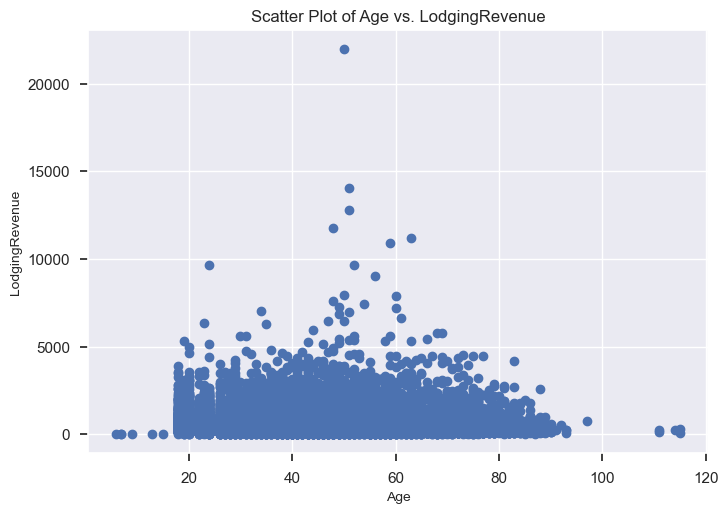

In [196]:
# Checking the relation between income and age
plt.scatter(ds_prep['Age'], ds_prep['LodgingRevenue'])
plt.title('Scatter Plot of Age vs. LodgingRevenue')
plt.xlabel('Age')
plt.ylabel('LodgingRevenue')
plt.show()

In [197]:
# Deleting rows where 'Age' is less than 18 - we cannot target these customers
ds_prep = ds_prep[ds_prep['Age'] >= 18]

In [198]:
ds_prep.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,73431.0,48.498904,14.717046,18.0,37.0,48.000000,58.000000,115.00
DaysSinceCreation,73431.0,685.362549,375.258636,36.0,374.0,706.000000,1001.000000,1385.00
AverageLeadTime,73431.0,88.613510,90.087425,-1.0,18.0,60.000000,135.000000,588.00
LodgingRevenue,73431.0,420.313446,420.171295,0.0,198.0,319.200012,498.975006,21981.00
OtherRevenue,73431.0,95.344681,141.749390,0.0,28.0,61.000000,117.000000,8859.25
BookingsCanceled,73431.0,0.003132,0.125322,0.0,0.0,0.000000,0.000000,15.00
BookingsNoShowed,73431.0,0.000817,0.039740,0.0,0.0,0.000000,0.000000,4.00
BookingsCheckedIn,73431.0,1.080320,0.966797,1.0,1.0,1.000000,1.000000,90.00
PersonsNights,73431.0,6.400117,4.655414,0.0,3.0,6.000000,8.000000,196.00
RoomNights,73431.0,3.254034,2.526592,1.0,2.0,3.000000,4.000000,196.00


**Negative Values** 

In [199]:
# Checking the number of negative values for AverageLeadTime
condition4 = ds_prep['AverageLeadTime'] < 0
rows_w_condition4 = ds_prep[condition4]
count_4 = len(rows_w_condition4)

print(count_4)
rows_w_condition4

12


,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
24828,USA,24.0,870.0,0xEEE451C018A695CC592A21016B9713CCE1CAD0CEF039...,0x855CC6ADF35259086B24B2639DD34563A20FD464BF0B...,-1.0,77.489998,3.0,0.0,0.0,1.0,3.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
41339,CHN,33.0,558.0,0x61B41490861314B7148F76EE7D7E17A240A86B45259D...,0x4CDEF046A3A97AAC6BD603F2250C8ACCB068C39995C4...,-1.0,129.000000,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
44847,FRA,57.0,499.0,0x7E60C14F1CDF540841373495CA352FA8579EA1166911...,0xD3D49D29C16B32E2DF23CB16128500175E12671B6DD3...,-1.0,149.000000,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
44851,FRA,62.0,499.0,0x8F817FC15C5606A27141C5FF717456FA9D3D7CE71A48...,0xE71E1E35741B667B50E3BDAD6AE5AE2283DDA0FE50F5...,-1.0,149.000000,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
44857,FRA,61.0,499.0,0x7DD53BA3E94C8D8B171B9D50041DC3A23E6F4752A3A8...,0x814B89362FCA5770AEDC4485136D7F673F78793CE218...,-1.0,149.000000,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
45866,ESP,46.0,485.0,0xBBBA5623819CD060BB49D9D700348FFEF885F825D019...,0x54D0B32490EA6DAB16F26AFBDAD5037A89E1BDA62B54...,-1.0,159.000000,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
46912,USA,70.0,468.0,0x4567E92118939CF20A432369E32BA8959502682AD473...,0x2A1EA7292AF2D9BB083726E0961A38A54950480886BA...,-1.0,95.199997,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
49281,GBR,46.0,424.0,0x2FFEF9FB8750A5B78550558BCAB6E6FE0EEFB92B53F9...,0x8FDCAADFD9772221E36C47D962BF5BEFC049103778EC...,-1.0,282.000000,24.0,0.0,0.0,1.0,4.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
51194,BRA,31.0,394.0,0xCD4216685825A5A65B100A4F8F19366A23B2BDDE8E29...,0x43126A8B69B8B1E3C1D4513EE586ABE2910947964929...,-1.0,209.000000,2.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
69879,NLD,28.0,45.0,0x3EF57FE4B2C2A74A125FAEF2BF176C04F5DEEDB842E4...,0x87FA9C39B0CD30CE3BEE596173C32F38D36403A0E914...,-1.0,227.000000,16.0,0.0,0.0,1.0,2.0,1.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,1,0,0,0,0


In [200]:
# Correcting those values by taking their absolute value 
ds_prep['AverageLeadTime'] = ds_prep['AverageLeadTime'].abs()

In [201]:
ds_clean = ds_prep.copy()

## Feature engineering

- In clustering variables with small variance will not be considered - BookingsCheckedIn
- Name and ID will not be considered as well - unique values, huge cardinality

In [202]:
# Counts for each unique value in 'Nationality'
nationality_counts = ds_clean['Nationality'].value_counts()
for index, value in nationality_counts.items():
    print(index, value)

FRA 11297
DEU 10291
GBR 7867
PRT 7482
ESP 4417
USA 3347
ITA 2989
BEL 2782
NLD 2563
BRA 2396
IRL 1929
CHE 1856
AUT 1305
CAN 1260
SWE 1109
ISR 786
CHN 777
NOR 708
POL 703
AUS 664
FIN 566
DNK 564
RUS 497
ROU 418
HUN 275
JPN 248
CZE 224
LUX 213
GRC 199
TUR 181
IND 170
ARG 162
KOR 161
AGO 160
MEX 156
HRV 143
MAR 143
BGR 132
SRB 131
EST 109
NZL 92
UKR 86
SVK 79
CHL 74
DZA 70
COL 68
LTU 66
SVN 66
LVA 66
CYP 66
ZAF 65
IRN 64
ISL 62
MOZ 62
TWN 57
SGP 37
AZE 36
THA 35
LBN 34
URY 33
TUN 30
MLT 29
EGY 29
PHL 28
PER 28
ARE 27
SAU 25
ECU 24
VEN 22
BLR 21
MYS 19
JOR 18
IDN 18
MKD 17
CMR 17
CRI 17
BIH 16
CPV 16
KAZ 16
ALB 15
PAN 14
NGA 13
KWT 12
BOL 12
VNM 11
PAK 11
GEO 10
ARM 10
DOM 10
KEN 9
IRQ 9
GTM 8
QAT 8
SEN 8
SYC 8
BGD 7
SYR 7
UGA 7
RWA 7
CUB 6
SUR 6
LKA 6
MUS 6
LBY 6
SMR 6
OMN 6
COD 6
MLI 5
PRY 5
BRB 5
HKG 5
SLV 5
BHR 5
GNB 5
LIE 5
COM 4
CAF 4
TGO 4
NAM 4
MCO 4
ATF 4
MNE 4
PRI 4
AND 3
BEN 3
ASM 3
GIB 3
KGZ 3
UZB 3
ABW 3
JAM 3
GHA 3
MDV 3
CIV 3
GAB 3
AFG 2
HTI 2
MMR 2
AIA 2
NIC 2
VIR 2
SPM 2
BW

**Continent column legend:**
 
 - Europe: `EU`
 - North America: `NA`
 - South America: `SA`
 - Asia: `AS`
 - Oceania: `OC`
 - Africa: `AF`
 - Antarctica : `AN`

In [203]:
#Continent column
continent_dict = {
    'FRA': 'EU', 'DEU': 'EU', 'PRT': 'EU', 'GBR': 'EU', 'ESP': 'EU',
    'ITA': 'EU', 'BEL': 'EU', 'NLD': 'EU', 'IRL': 'EU', 'CHE': 'EU',
    'AUT': 'EU', 'SWE': 'EU', 'NOR': 'EU', 'POL': 'EU', 'FIN': 'EU',
    'DNK': 'EU', 'RUS': 'EU', 'ROU': 'EU', 'HUN': 'EU', 'CZE': 'EU',
    'LUX': 'EU', 'GRC': 'EU', 'BGR': 'EU', 'HRV': 'EU', 'SRB': 'EU',
    'UKR': 'EU', 'EST': 'EU', 'SVK': 'EU', 'LVA': 'EU', 'LTU': 'EU',
    'SVN': 'EU', 'ISL': 'EU', 'CYP': 'EU', 'MLT': 'EU', 'ALB': 'EU',
    'MKD': 'EU', 'BIH': 'EU', 'BLR': 'EU', 'SMR': 'EU', 'LIE': 'EU',
    'AND': 'EU', 'GIB': 'EU', 'MCO': 'EU', 'SLV': 'EU', 'SJM': 'EU','MNE': 'EU',
    'USA': 'NA', 'CAN': 'NA', 'MEX': 'NA','JAM': 'NA',
    'GTM': 'NA','GRD': 'NA','PRI': 'NA','AIA': 'NA','KNA': 'NA',
    'CRI': 'NA', 'PAN': 'NA', 'CUB': 'NA', 'BRB': 'NA','ABW': 'NA','DMA': 'NA',
    'BRA': 'SA', 'ARG': 'SA', 'CHL': 'SA', 'COL': 'SA','DOM': 'NA','HTI': 'NA',
    'PER': 'SA', 'VEN': 'SA', 'ECU': 'SA', 'BOL': 'SA','LCA': 'NA','BMU': 'NA',
    'PER': 'SA', 'VEN': 'SA', 'ECU': 'SA', 'BOL': 'SA','LCA': 'NA','BMU': 'NA',
    'PRY': 'SA', 'URY': 'SA', 'GUY': 'SA', 'SUR': 'SA',
    'ISR': 'AS', 'CHN': 'AS', 'IND': 'AS', 'KOR': 'AS', 'JPN': 'AS', 'TUR': 'AS','THA': 'AS','SGP': 'AS','HKG': 'AS',
    'IRN': 'AS', 'PHL': 'AS', 'ARE': 'AS', 'QAT': 'AS', 'KAZ': 'AS', 'VNM': 'AS','BGD': 'AS','LBN': 'AS','KGZ': 'AS',
    'IDN': 'AS', 'MYS': 'AS', 'PAK': 'AS', 'ARM': 'AS', 'GEO': 'AS', 'KWT': 'AS','AZE': 'AS','MDV': 'AS',
    'OMN': 'AS', 'BHR': 'AS', 'IRQ': 'AS', 'JOR': 'AS', 'LKA': 'AS', 'SYR': 'AS','SAU': 'AS','LAO': 'AS',
    'AFG': 'AS', 'UZB': 'AS', 'TJK': 'AS', 'YEM': 'AS', 'SDN': 'AS', 'IOT': 'AS','TWN': 'AS','TMP': 'AS',
    'AUS': 'OC', 'NZL': 'OC', 'FJI': 'OC', 'PNG': 'OC', 'WSM': 'OC',
    'TON': 'OC', 'KIR': 'OC', 'NRU': 'OC', 'VUT': 'OC', 'SLB': 'OC',
    'MHL': 'OC', 'PLW': 'OC', 'FSM': 'OC', 'COK': 'OC', 'NCL': 'OC',
    'PYF': 'OC', 'PCN': 'OC', 'NIU': 'OC', 'TKL': 'OC', 'GUM': 'OC',
    'MNP': 'OC', 'ASM': 'OC', 'WLF': 'OC', 'TUV': 'OC', 'NF': 'OC',
    'ZAF': 'AF', 'MAR': 'AF', 'DZA': 'AF', 'EGY': 'AF', 'NGA': 'AF', 'MOZ': 'AF', 'AGO': 'AF','CPV': 'AF','TUN': 'AF','MUS': 'AF','MDG': 'AF',
    'SEN': 'AF', 'ETH': 'AF', 'UGA': 'AF', 'KEN': 'AF', 'TZA': 'AF', 'SOM': 'AF', 'CMR': 'AF', 'GHA': 'AF', 'CIV': 'AF', 'NGA': 'AF',
    'ZAF': 'AF', 'DZA': 'AF', 'EGY': 'AF', 'MAR': 'AF', 'SDN': 'AF', 'ETH': 'AF', 'MLI': 'AF', 'BFA': 'AF', 'NER': 'AF','MRT': 'AF',
    'TGO': 'AF', 'BEN': 'AF', 'MR': 'AF', 'SEN': 'AF', 'GMB': 'AF', 'GNB': 'AF', 'SLE': 'AF', 'LBR': 'AF', 'CIV': 'AF','STP': 'AF',
    'GH': 'AF', 'TOG': 'AF', 'BJ': 'AF', 'NG': 'AF', 'CM': 'AF', 'CF': 'AF', 'TD': 'AF', 'ER': 'AF', 'DJ': 'AF','MWI': 'AF',
    'SO': 'AF', 'ET': 'AF', 'UG': 'AF', 'RW': 'AF', 'BI': 'AF', 'MZ': 'AF', 'ZM': 'AF', 'ZW': 'AF', 'MW': 'AF','COM': 'AF',
    'LS': 'AF', 'BW': 'AF', 'NA': 'AF', 'ZA': 'AF', 'SZ': 'AF', 'KM': 'AF', 'MG': 'AF', 'MU': 'AF', 'SC': 'AF','GAB': 'AF',
    'ST': 'AF', 'KE': 'AF', 'TZ': 'AF', 'UG': 'AF', 'RW': 'AF', 'BI': 'AF', 'DJ': 'AF', 'ER': 'AF', 'ET': 'AF','BDI': 'AF',
    'SO': 'AF', 'SD': 'AF', 'SS': 'AF','COD': 'AF','LBY': 'AF','NAM': 'AF','RWA': 'AF','NAM': 'AF','SYC': 'AF','GIN': 'AF',
    'ATA': 'AN','ATF': 'AN',
    'CAF': 'AF','FRO': 'EU', 'ZWE': 'AF','BWA': 'AF','ERI': 'AF','SPM': 'NA','JEY': 'EU','GNQ': 'AF','NIC': 'NA', 'SWZ': 'AF',
    'CYM': 'NA','ATG': 'NA','FLK': 'SA','BHS': 'NA', 'UMI': 'OC','TKM': 'AS', 'MMR': 'AS', 'VIR': 'NA', 
    'VCT': 'NA', 'GUF': 'SA','TCD': 'AF','NPL': 'AS','TTO': 'NA','HND': 'NA',
}

# Assigning continents based on the 'Nationality' column
ds_clean['Continent'] = ds_clean['Nationality'].map(lambda x: continent_dict.get(x, 'Unknown'))

print(ds_clean['Continent'].value_counts())

Continent
EU    61391
NA     4852
AS     2863
SA     2833
OC      767
AF      719
AN        6
Name: count, dtype: int64


In [204]:
# We join OC, AF, AN because their count is insignificant
continent_dict_2 = {
    'OC': 'Other', 'AF': 'Other', 'AN': 'Other','EU': 'EU', 'NA': 'NA', 'AS': 'AS', 'SA':'SA'}

ds_clean['Continent'] = ds_clean['Continent'].map(lambda x: continent_dict_2.get(x, 'Unknown'))

print(ds_clean['Continent'].value_counts())

Continent
EU       61391
NA        4852
AS        2863
SA        2833
Other     1492
Name: count, dtype: int64


In [205]:
ds_clean[ds_clean['Continent'] == 'Unknown'] 

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Continent


In [206]:
ds_clean.head()

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Continent
0,PRT,52.0,440.0,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59.0,292.0,82.300003,1.0,0.0,2.0,6.0,4.0,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0,EU
1,FRA,61.0,1385.0,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93.0,240.0,60.000000,0.0,0.0,1.0,10.0,5.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,EU
2,JPN,55.0,1385.0,0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...,0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...,58.0,230.0,24.000000,0.0,0.0,1.0,4.0,2.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,AS
3,FRA,33.0,1385.0,0x165B609162C92BF563E96DB03539363F07E784C219A8...,0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...,38.0,535.0,94.000000,0.0,0.0,1.0,10.0,5.0,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0,EU
4,IRL,26.0,1385.0,0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...,0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...,96.0,174.0,69.000000,0.0,0.0,1.0,6.0,3.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0,EU


In [207]:
# Creating a new feature that stores the number os special requests for each customer
columns_to_sum = ['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 
                  'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed', 
                  'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 
                  'SRQuietRoom']

ds_clean['NumberOfRequests'] = ds_clean[columns_to_sum].sum(axis=1)
print(ds_clean['NumberOfRequests'].value_counts())

NumberOfRequests
0    33588
1    32428
2     6763
3      610
4       42
Name: count, dtype: int64


In [208]:
#TotalRevenue
ds_clean['TotalRevenue'] = (ds_clean['LodgingRevenue'] + ds_clean['OtherRevenue']).round(0).astype(int)

#AverageDailySpend - Revenew spent per day in the hotel
ds_clean['AverageDailySpend'] = np.where(ds_clean['PersonsNights'] > 0, 
                                         ds_clean['TotalRevenue'] / ds_clean['PersonsNights'], 
                                         0).round(0).astype(int)

#Cancellation and No Show Ratio
ds_clean['NotComingRatio'] = ((ds_clean['BookingsCanceled'] + ds_clean['BookingsNoShowed'])/
                                (ds_clean['BookingsCanceled'] + ds_clean['BookingsNoShowed']+ds_clean['BookingsCheckedIn'])).round(2)
average_ratio = ds_clean['NotComingRatio'].mean()

In [209]:
#136 people canceled or didn't show (counting from people who checked in the hotel at least once)
ds_clean[ds_clean['NotComingRatio'] > 0]

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Continent,NumberOfRequests,TotalRevenue,AverageDailySpend,NotComingRatio
0,PRT,52.0,440.0,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59.0,292.000000,82.300003,1.0,0.0,2.0,6.0,4.0,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0,EU,0,374,62,0.33
178,PRT,45.0,1381.0,0x1807CF24CEE774AE27B94BF054672CCCA0ACCDE2DE0A...,0xB9E8FB9C662CC3FDDF9F55E213E0F3BF59537450394C...,2.0,1086.000000,162.000000,0.0,1.0,11.0,22.0,18.0,Corporate,Corporate,0,0,0,0,0,0,0,0,1,0,0,0,0,EU,1,1248,57,0.08
310,PRT,46.0,1362.0,0x65A26CC5AA4DA0FE145C848C955F2D8A7F852DB78547...,0x5E9904C097C496B8C002D9E7F9F1AC145252C226DBB7...,1.0,0.000000,0.000000,1.0,0.0,2.0,3.0,2.0,Direct,Direct,0,0,0,0,0,0,0,1,0,0,0,0,0,EU,1,0,0,0.33
446,ESP,57.0,1351.0,0xD47478D7647A16F8679FF66BD629A1B436E9544A94BC...,0xBE3B88830D94C45CF18A1BF8B36D2A4782FD14CE46B2...,3.0,219.000000,32.500000,0.0,2.0,1.0,3.0,3.0,Direct,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0,EU,0,252,84,0.67
1091,PRT,31.0,1322.0,0xBB3CF9AE87C477B1B8C6A74FC91EC6D0C912C58E4641...,0x71D7A5D69355E5B1E7D6F42502BFCE2D7175BC79EB6A...,18.0,53.000000,14.000000,0.0,1.0,1.0,2.0,1.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,1,0,0,0,0,EU,1,67,34,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73217,PRT,43.0,942.0,0x56D9FA4A4285FE3795C8FA817778CA28E3DE04879D5B...,0xEC67CD8FC7ADA14945614ECD2AF70547821B34F17DC8...,40.5,543.000000,63.000000,1.0,0.0,3.0,9.0,9.0,Corporate,Corporate,0,0,0,0,0,0,0,1,0,0,0,0,0,EU,1,606,67,0.25
73260,PRT,54.0,1366.0,0x66458A811C5E603E5722AE10EE5272FD804EE0999F41...,0xF0FC75EF8461932A8A0653883FF52D105CF88CD34225...,2.0,1246.000000,427.500000,2.0,1.0,15.0,16.0,15.0,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0,EU,0,1674,105,0.17
73298,BEL,41.0,396.0,0x0DDD59AB8BE1C32862CA17DEF932E85C47234A46079E...,0xF4009B9C84ED379CE6B0F056F3852348C15E8AF167F3...,50.0,288.690002,152.070007,1.0,0.0,1.0,6.0,3.0,Travel Agent/Operator,Direct,0,0,0,0,0,0,0,1,0,0,0,0,1,EU,2,441,74,0.50
73345,PRT,50.0,1315.0,0x382BF2A6BF57870D9831631A7ACA7B30CB42FE9FEEDF...,0xF728641F469966A5AA8906B76CC8C3083A0BDEC9F24F...,34.0,21981.000000,1616.000000,1.0,0.0,30.0,64.0,187.0,Corporate,Direct,0,0,0,0,0,0,0,0,0,0,0,0,0,EU,0,23597,369,0.03


In [210]:
# Count ocurrences for each unique value in each feature
for column in ds_clean.columns:
    print(ds_clean[column].value_counts())

Nationality
FRA    11297
DEU    10291
GBR     7867
PRT     7482
ESP     4417
       ...  
MDG        1
SWZ        1
SOM        1
ATG        1
GRD        1
Name: count, Length: 185, dtype: int64
Age
50.0     1952
51.0     1949
52.0     1924
54.0     1913
48.0     1911
         ... 
111.0       2
92.0        1
114.0       1
97.0        1
91.0        1
Name: count, Length: 78, dtype: int64
DaysSinceCreation
767.0     182
762.0     182
1208.0    154
387.0     146
522.0     141
         ... 
1370.0      3
1363.0      3
763.0       3
36.0        3
1209.0      1
Name: count, Length: 1349, dtype: int64
NameHash
0x264D8DC78C198A35ED647032AC1EBEBC70D4BB9F64F2D8F57D69EE39504B4176    5
0x749560D9E536F4410815950837B053F5C50654376DF838F566E1448F2555B9FC    4
0xE6C30B3668E7753B8F0327C970688E126ADAACCD56C00BEF2611F3C0ABCA5432    4
0x2668F152BFB6EF4E27E819FAA92C53AFF0A0F13152E7FE34FA9574A3C135AE0F    4
0xF90B1790F3146FF3A33840914DD2056189BCD6C1F0FDC5558EA3567EFE0BBF6C    4
                             

In [211]:
#Dropping not highly discriminative variables 
drop_binary = ['SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 
                  'SRBathtub', 'SRShower', 
                  'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar']

ds_new = ds_clean.drop(columns= drop_binary, inplace=False)

In [212]:
ds_new

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,MarketSegment,SRHighFloor,SRCrib,SRKingSizeBed,SRTwinBed,SRQuietRoom,Continent,NumberOfRequests,TotalRevenue,AverageDailySpend,NotComingRatio
0,PRT,52.0,440.0,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59.0,292.000000,82.300003,1.0,0.0,2.0,6.0,4.0,Corporate,Corporate,0,0,0,0,0,EU,0,374,62,0.33
1,FRA,61.0,1385.0,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93.0,240.000000,60.000000,0.0,0.0,1.0,10.0,5.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,EU,0,300,30,0.00
2,JPN,55.0,1385.0,0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...,0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...,58.0,230.000000,24.000000,0.0,0.0,1.0,4.0,2.0,Travel Agent/Operator,Other,0,0,0,0,0,AS,0,254,64,0.00
3,FRA,33.0,1385.0,0x165B609162C92BF563E96DB03539363F07E784C219A8...,0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...,38.0,535.000000,94.000000,0.0,0.0,1.0,10.0,5.0,Travel Agent/Operator,Other,0,0,1,0,0,EU,1,629,63,0.00
4,IRL,26.0,1385.0,0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...,0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...,96.0,174.000000,69.000000,0.0,0.0,1.0,6.0,3.0,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,EU,0,243,40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73432,PRT,49.0,205.0,0x8D0E0C2D2FF051C5B35637AA0D3EC07EB921FC5FB29B...,0xFF91D161864F72F305F302EC7838C11B4A1691E02F0F...,21.0,99.000000,28.000000,0.0,0.0,1.0,1.0,1.0,Direct,Direct,0,0,0,0,0,EU,0,127,127,0.00
73433,PRT,57.0,1119.0,0x0A2B8DA5B59919CC06FE27D049E3ED6EB0CDD8223134...,0xFF9675AE80F23755648A49A81175B285AC7A9BFBB9DD...,3.0,1832.199951,51.000000,0.0,0.0,2.0,9.0,6.0,Travel Agent/Operator,Other,0,0,0,0,1,EU,1,1883,209,0.00
73434,ESP,46.0,1324.0,0x9A6D4033D479DB80B1EE58A38193FC1481E0943A249B...,0xFFC8E8CE49A4A882225B210B488EB8959153A1CDD538...,58.0,423.000000,59.000000,0.0,0.0,2.0,5.0,4.0,Direct,Groups,0,0,0,0,0,EU,0,482,96,0.00
73435,NLD,43.0,673.0,0xC031D142FB99F0722FE4DFD4298AA57CC67C89C68E62...,0xFFD0ED500662142AB2E236798F4E5772353C5CA89DF3...,38.0,637.000000,259.000000,0.0,0.0,3.0,11.0,8.0,Travel Agent/Operator,Groups,0,0,0,0,0,EU,0,896,81,0.00


**Important**:
\
In case of continuous variables: Age, Total Revenue and Average Lead Time, binning them into intervals was applied 
(intervals which were equal regarding the number of observations in the interval and also regarding the size of the interval values). 
That was applied in order to try and make these variables seem more important in the clustering algorithm, however vast majority of the customers oscillates near the same values, so either way they end up spread between all clusters having similar results as for these 3 variables. Therefore, it was decided then to keep them in the continuous form to make the clustering clearer and easier to interpret.

## Outliers

In [213]:
ds_outliers = ds_new.copy()

In [214]:
# Updating variable lists
_num = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 
        'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 
        'RoomNights', 'NumberOfRequests', 'TotalRevenue', 'AverageDailySpend', 'NotComingRatio']

_cat = ds_outliers.columns.drop(_num).to_list()

In [215]:
# Obtaining the percentage of outliers for each feature
percentage_outliers_dict = {}

for variable in _num:
    Q1 = ds_outliers[variable].quantile(0.25)
    Q3 = ds_outliers[variable].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ds_outliers[(ds_outliers[variable] < lower_bound) | (ds_outliers[variable] > upper_bound)]
    percentage_outliers = (len(outliers) / len(ds_outliers)) * 100
    percentage_outliers_dict[variable] = percentage_outliers

for variable, percentage in percentage_outliers_dict.items():
    print(f"Percentage of outliers in '{variable}': {percentage:.2f}%")

Percentage of outliers in 'Age': 0.02%
Percentage of outliers in 'DaysSinceCreation': 0.00%
Percentage of outliers in 'AverageLeadTime': 2.47%
Percentage of outliers in 'LodgingRevenue': 6.48%
Percentage of outliers in 'OtherRevenue': 6.55%
Percentage of outliers in 'BookingsCanceled': 0.16%
Percentage of outliers in 'BookingsNoShowed': 0.06%
Percentage of outliers in 'BookingsCheckedIn': 4.28%
Percentage of outliers in 'PersonsNights': 3.49%
Percentage of outliers in 'RoomNights': 2.11%
Percentage of outliers in 'NumberOfRequests': 0.89%
Percentage of outliers in 'TotalRevenue': 6.44%
Percentage of outliers in 'AverageDailySpend': 8.48%
Percentage of outliers in 'NotComingRatio': 0.19%


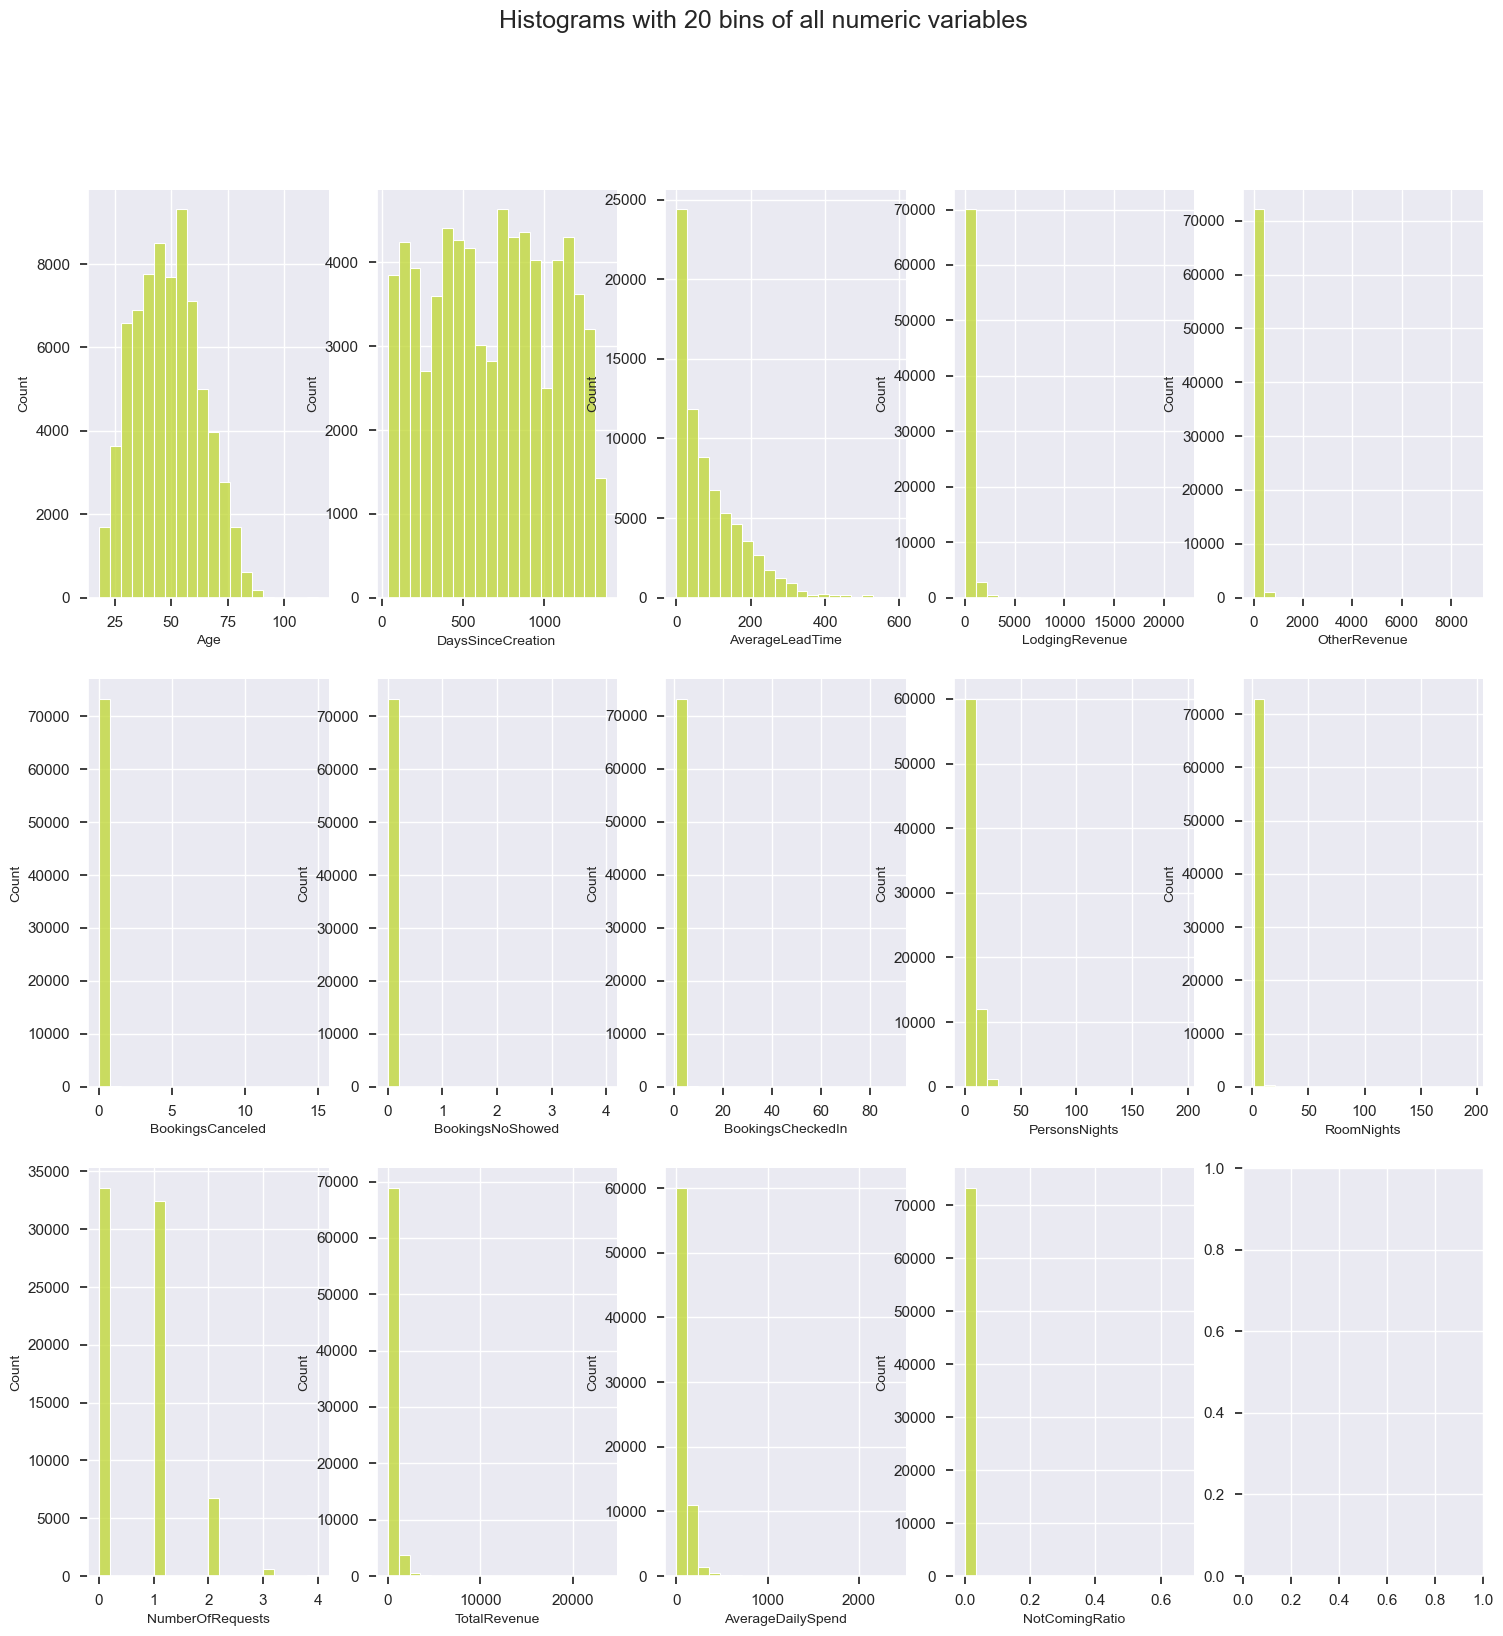

In [216]:
# HISTOGRAM (ALL NUMERIC VARIABLES)
fig, ax = plt.subplots(3, 5, figsize=(18,18))
for var, subplot in zip(ds_outliers[_num], ax.flatten()):
    g = sns.histplot(data=ds_outliers,
                bins=20,
                 x=var,
                 ax=subplot,
                 color='#bed62f',
                 kde=False)

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=18);


In [217]:
columns_to_transform = ['NumberOfRequests', 'AverageLeadTime']

In [218]:
#Applying a logarithmic transformation to reduce the % of outliers to 0.0 and make the distribuition more similar to the normal
ds_outliers[columns_to_transform] = np.log1p(ds_outliers[columns_to_transform].astype(float))

# Variables that had 0% or outliers after specified transformation: 
# yeo - johnson: 'AverageLeadTime','NumberOfRequests'
# log1p: 'NumberOfRequests', 'AverageLeadTime'

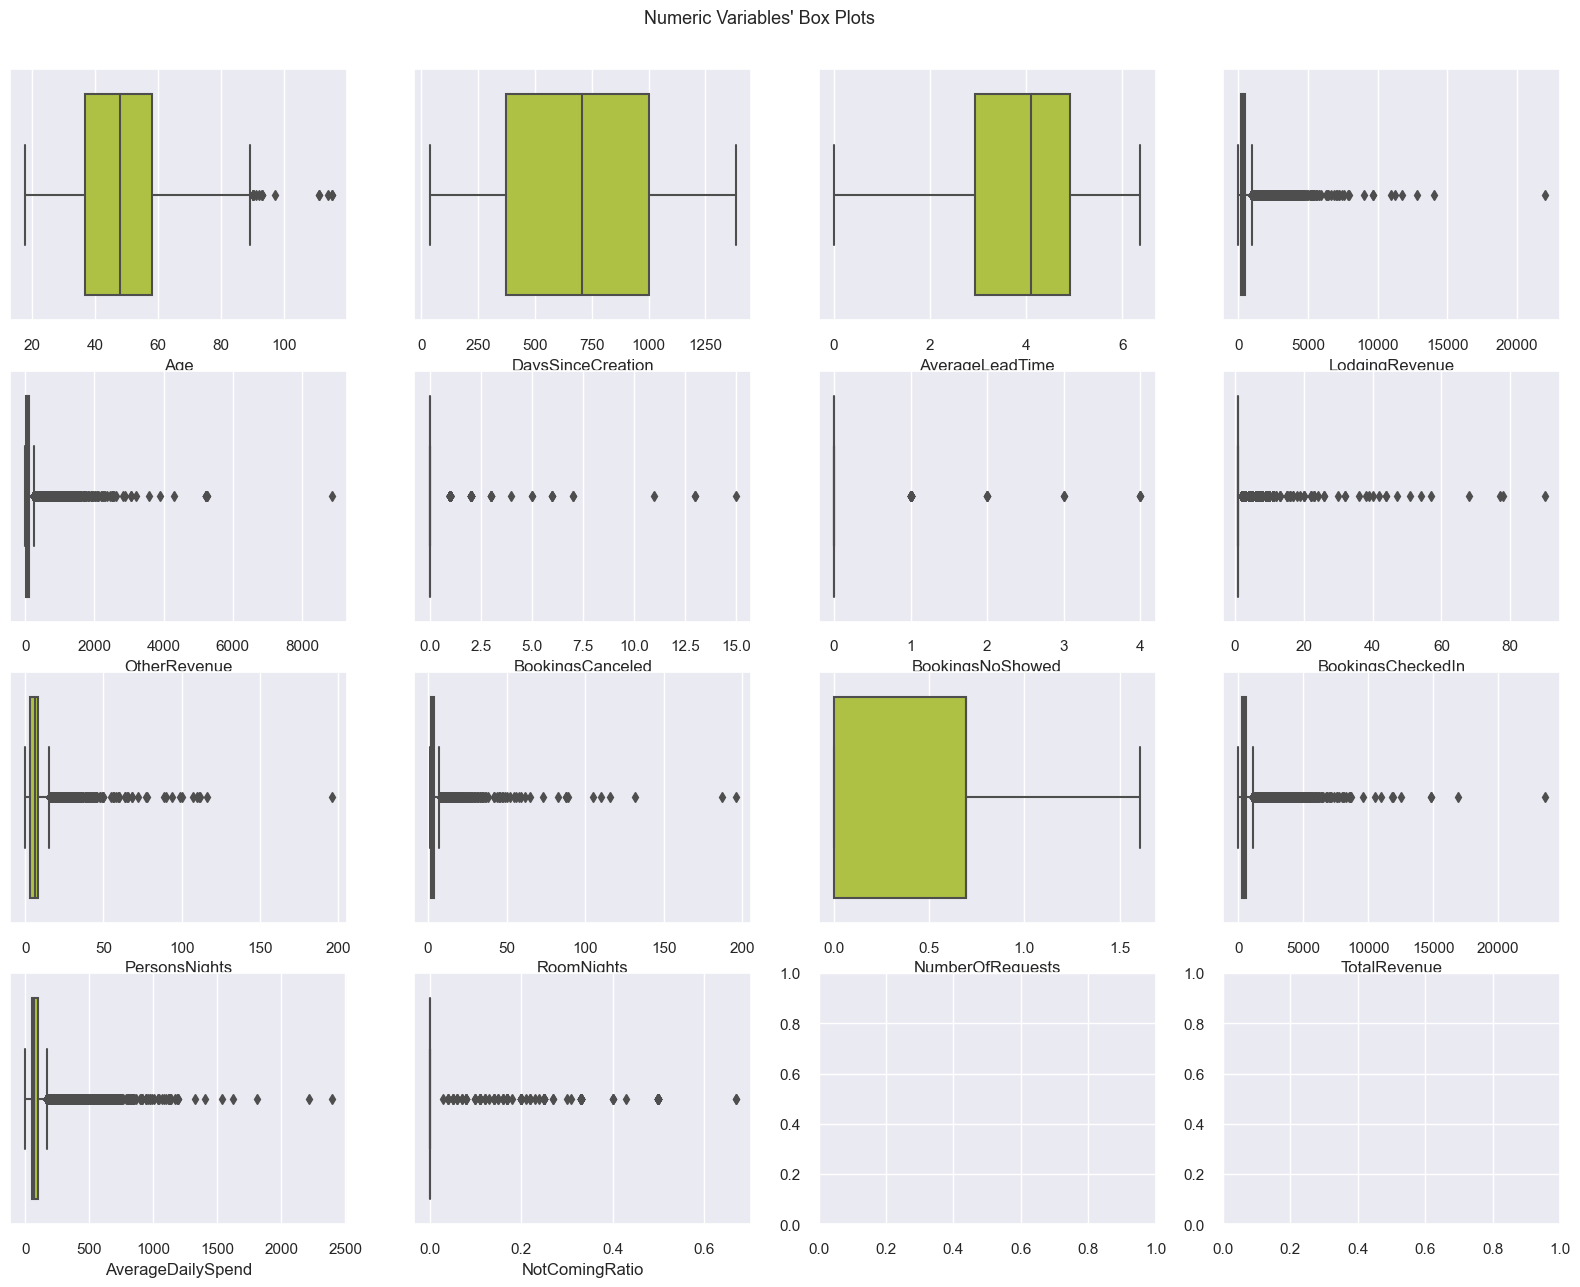

In [219]:
# Visualizing boxplots with outliers
sns.set()

fig, axes = plt.subplots(4, ceil(len(_num) / 4), figsize=(20, 15))

for ax, feat in zip(axes.flatten(), _num): 
    sns.boxplot(x=ds_outliers[feat], ax=ax, color='#bed62f')
   
title = "Numeric Variables' Box Plots"

plt.suptitle(title,fontsize=13, y=0.92)

plt.show()

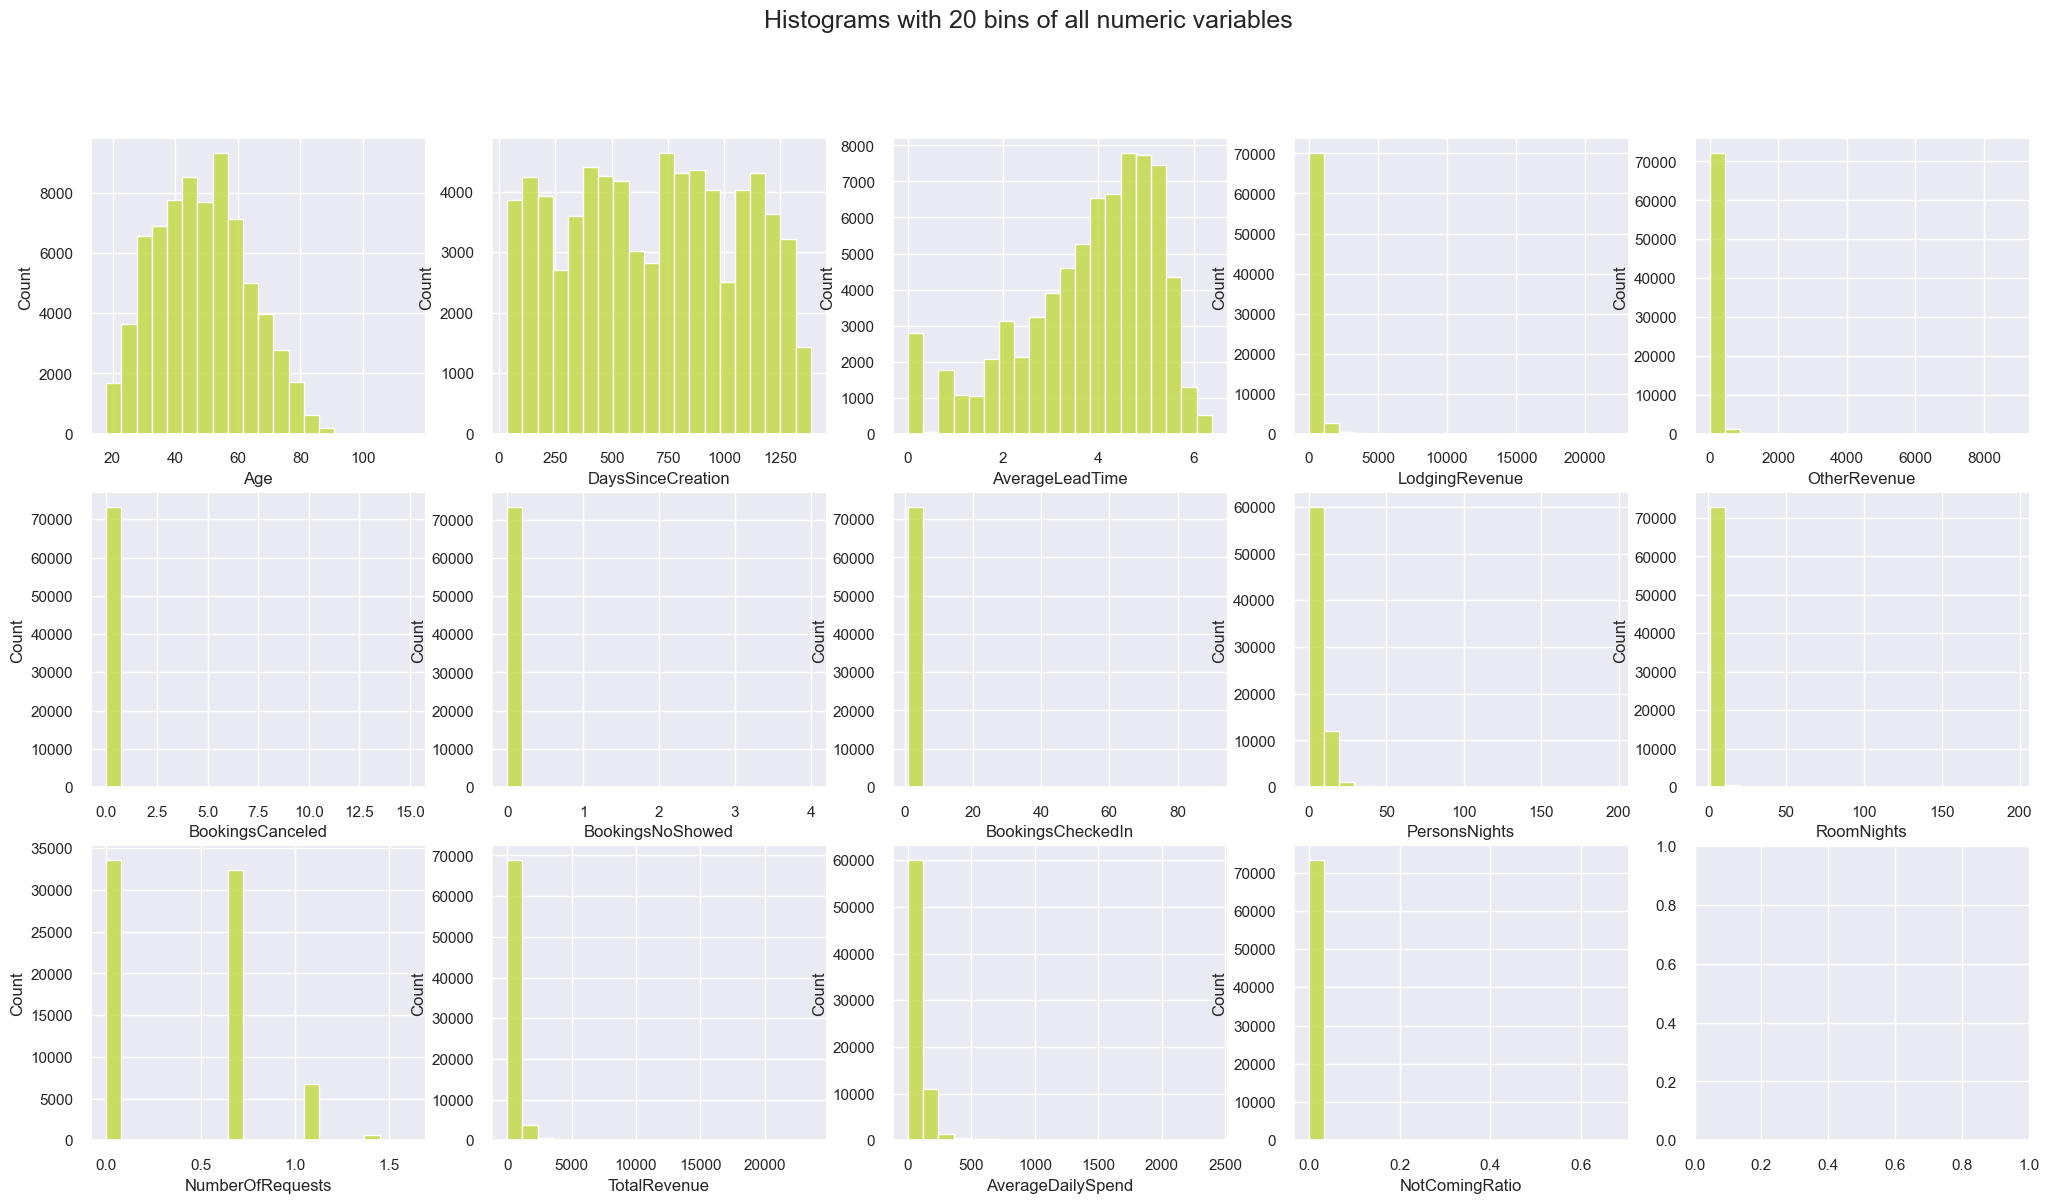

In [220]:
# HISTOGRAM (ALL NUMERIC VARIABLES)
fig, ax = plt.subplots(3, 5, figsize=(25,13))
for var, subplot in zip(ds_outliers[_num], ax.flatten()):
    g = sns.histplot(data=ds_outliers,
                bins=20,
                 x=var,
                 ax=subplot,
                 color='#bed62f',
                 kde=False)

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=18);

In [221]:
# Function cap_outliers to create a DataFrame with outliers capped at the specified columns' 25th and 75th percentile values.
def cap_outliers(df, columns):
    
    df_out = df.copy()
    for column in columns:
        q25, q75 = df_out[column].quantile(0.25), df_out[column].quantile(0.75)
        iqr = q75 - q25
        # You can adjust these factors if needed
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        
        # Capping the outliers
        df_out[column] = np.where(df_out[column] > upper_bound, upper_bound, df_out[column])
        df_out[column] = np.where(df_out[column] < lower_bound, lower_bound, df_out[column])
    
    return df_out

In [222]:
# Dealing with outliers for each feature
df_out = cap_outliers(ds_outliers, _num)

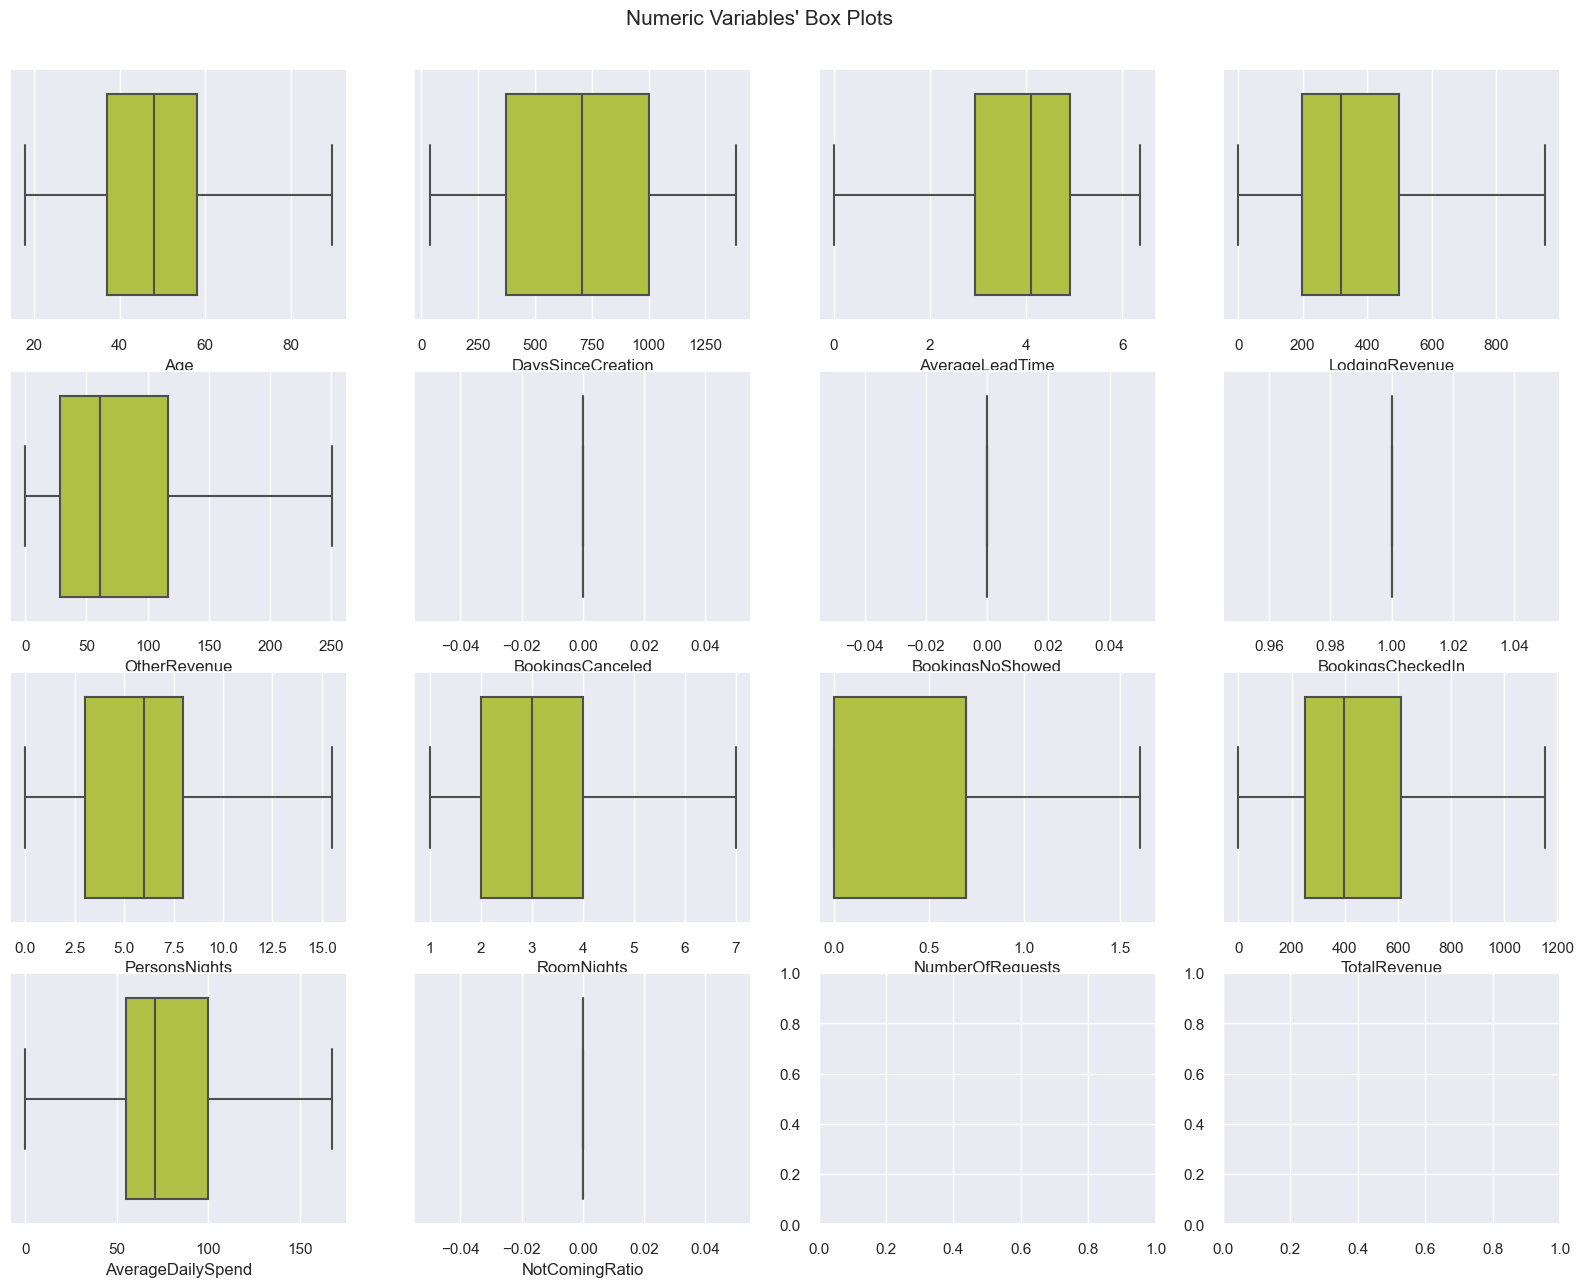

In [223]:
# Visualizing boxplots with outliers
sns.set()

fig, axes = plt.subplots(4, ceil(len(_num) / 4), figsize=(20, 15))

for ax, feat in zip(axes.flatten(), _num): 
    sns.boxplot(x=df_out[feat], ax=ax, color='#bed62f')
   
title = "Numeric Variables' Box Plots"

plt.suptitle(title,fontsize=15, y=0.92)

plt.show()

In [224]:
df_out.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,73431.0,48.496950,14.710245,18.0,37.000000,48.000000,58.000000,89.500000
DaysSinceCreation,73431.0,685.362549,375.258636,36.0,374.000000,706.000000,1001.000000,1385.000000
AverageLeadTime,73431.0,3.781185,1.465562,0.0,2.944439,4.110874,4.912655,6.378426
LodgingRevenue,73431.0,381.212067,242.176147,0.0,198.000000,319.200012,498.975006,950.437500
OtherRevenue,73431.0,82.891502,70.356621,0.0,28.000000,61.000000,117.000000,250.500000
BookingsCanceled,73431.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BookingsNoShowed,73431.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BookingsCheckedIn,73431.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
PersonsNights,73431.0,6.198159,3.750005,0.0,3.000000,6.000000,8.000000,15.500000
RoomNights,73431.0,3.151571,1.583508,1.0,2.000000,3.000000,4.000000,7.000000


In [225]:
# Removing variables with only one unique value
redundant = ['BookingsCanceled',
 'BookingsNoShowed',
 'BookingsCheckedIn','NotComingRatio']

df_out = df_out.drop(columns= redundant, inplace=False)

upd_num = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 
        'RoomNights', 'NumberOfRequests', 'TotalRevenue', 'AverageDailySpend',  'PersonsNights']

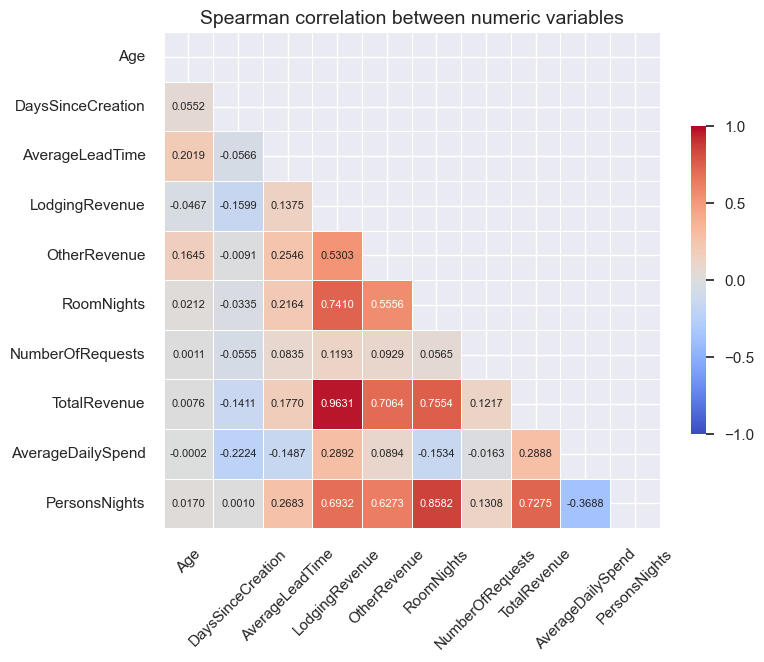

In [226]:
# CORRELATION 

# Create correlation matrix
corr = df_out[upd_num].corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(8, 10))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [227]:
# Removing columns that are highly correlated
# We leave total revenue, and delete 'LodgingRevenue', 'OtherRevenue' as it already includes these variabless
# We also remove PersonsNights, cause Room Nights is a more used metric in the industry
# Also we remove Market Segment as this is an old clustering reesult, whereas we want to do a new one

cols = ['PersonsNights','LodgingRevenue', 'OtherRevenue', 'MarketSegment']
ds_done = df_out.drop(columns=cols, inplace=False)

In [228]:
ds_done

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,RoomNights,DistributionChannel,SRHighFloor,SRCrib,SRKingSizeBed,SRTwinBed,SRQuietRoom,Continent,NumberOfRequests,TotalRevenue,AverageDailySpend
0,PRT,52.0,440.0,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,4.094345,4.0,Corporate,0,0,0,0,0,EU,0.000000,374.0,62.0
1,FRA,61.0,1385.0,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,4.543295,5.0,Travel Agent/Operator,0,0,0,0,0,EU,0.000000,300.0,30.0
2,JPN,55.0,1385.0,0xA3CF1A4692BE0A17CFD3BFD9C07653556BDADF5F4BE7...,0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...,4.077537,2.0,Travel Agent/Operator,0,0,0,0,0,AS,0.000000,254.0,64.0
3,FRA,33.0,1385.0,0x165B609162C92BF563E96DB03539363F07E784C219A8...,0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...,3.663562,5.0,Travel Agent/Operator,0,0,1,0,0,EU,0.693147,629.0,63.0
4,IRL,26.0,1385.0,0x9BEECEE0C18B0957C7424443643948E99A0EC8326EF9...,0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...,4.574711,3.0,Travel Agent/Operator,0,0,0,0,0,EU,0.000000,243.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73432,PRT,49.0,205.0,0x8D0E0C2D2FF051C5B35637AA0D3EC07EB921FC5FB29B...,0xFF91D161864F72F305F302EC7838C11B4A1691E02F0F...,3.091042,1.0,Direct,0,0,0,0,0,EU,0.000000,127.0,127.0
73433,PRT,57.0,1119.0,0x0A2B8DA5B59919CC06FE27D049E3ED6EB0CDD8223134...,0xFF9675AE80F23755648A49A81175B285AC7A9BFBB9DD...,1.386294,6.0,Travel Agent/Operator,0,0,0,0,1,EU,0.693147,1152.0,167.5
73434,ESP,46.0,1324.0,0x9A6D4033D479DB80B1EE58A38193FC1481E0943A249B...,0xFFC8E8CE49A4A882225B210B488EB8959153A1CDD538...,4.077537,4.0,Direct,0,0,0,0,0,EU,0.000000,482.0,96.0
73435,NLD,43.0,673.0,0xC031D142FB99F0722FE4DFD4298AA57CC67C89C68E62...,0xFFD0ED500662142AB2E236798F4E5772353C5CA89DF3...,3.663562,7.0,Travel Agent/Operator,0,0,0,0,0,EU,0.000000,896.0,81.0


In [229]:
# Create a dataframe with just the identifiers
identifiers_df = ds_done[['NameHash', 'DocIDHash']].copy()

# Add a column of indexes before removing identifiers
ds_done['UniqueID'] = range(1, len(ds_done) + 1)

# Make sure to add the same unique key to the dataframe of identifiers
identifiers_df['UniqueID'] = ds_done['UniqueID']

ds_done = ds_done.drop(['NameHash', 'DocIDHash'], axis=1)

In [230]:
ds_done = ds_done.set_index('UniqueID')
identifiers_df = identifiers_df.set_index('UniqueID')

## Encoding

In [231]:
# Create a foreigner column
ds_done['Foreigner'] = ds_done['Nationality'].apply(lambda x: 0 if x == 'PRT' else 1)
print(ds_done['Foreigner'].value_counts())

Foreigner
1    65949
0     7482
Name: count, dtype: int64


In [232]:
# One-hot-encode the variable 'DistributionChannel'
cols = ['DistributionChannel']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
ds_done = ce_one_hot.fit_transform(ds_done)

In [233]:
# Applying One-Hot Encoding to the Continent column
ds_done = pd.get_dummies(ds_done, columns=['Continent'], prefix='Cont', prefix_sep='_')

In [234]:
# Removing Nationality as it has too many levels and is redundant 
cols = ['Nationality']
ds_done.drop(columns=cols, inplace=True)

In [235]:
# Get a copy of the dataframe before normalization for results' analysis
ds_beforeNorm = ds_done.copy(deep=True)

In [236]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
ds_norm = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(ds_done.values), columns=ds_done.columns,index=ds_done.index)

In [237]:
# Check dataframe structure and statistics after all transformations
print(ds_norm.shape)
ds_norm.describe(include='all').T

(73431, 22)


,count,mean,std,min,25%,50%,75%,max
Age,73431.0,0.426531,0.205738,0.0,0.265734,0.419580,0.559441,1.0
DaysSinceCreation,73431.0,0.481366,0.278174,0.0,0.250556,0.496664,0.715345,1.0
AverageLeadTime,73431.0,0.592808,0.229769,0.0,0.461625,0.644497,0.770199,1.0
RoomNights,73431.0,0.358595,0.263926,0.0,0.166667,0.333333,0.500000,1.0
DistributionChannel_Corporate,73431.0,0.029633,0.169575,0.0,0.000000,0.000000,0.000000,1.0
DistributionChannel_Travel Agent/Operator,73431.0,0.824761,0.380174,0.0,1.000000,1.000000,1.000000,1.0
DistributionChannel_Direct,73431.0,0.137748,0.344638,0.0,0.000000,0.000000,0.000000,1.0
DistributionChannel_GDS Systems,73431.0,0.007858,0.088295,0.0,0.000000,0.000000,0.000000,1.0
SRHighFloor,73431.0,0.041427,0.199276,0.0,0.000000,0.000000,0.000000,1.0
SRCrib,73431.0,0.010622,0.102516,0.0,0.000000,0.000000,0.000000,1.0


## Analyze Principal Components

(73431, 2)


C:\Users\madal\AppData\Local\Temp\ipykernel_14240\3934972394.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca2[:, 0], X_pca2[:, 1], edgecolor='none', alpha=0.5, cmap='viridis')


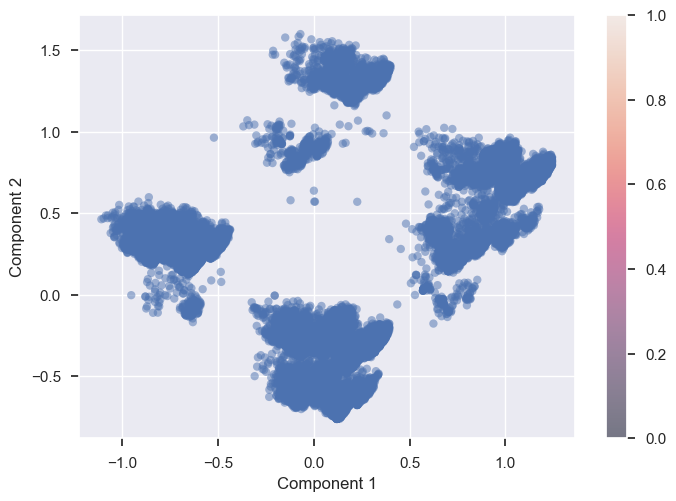

In [238]:
# Let's use PCA to visualize with only two components
pca2 = PCA(n_components = 2)
pca2.fit(ds_norm)
X_pca2 = pca2.transform(ds_norm)
print(X_pca2.shape)

# Scatter plot of the two Principal Components by the "target" to see if there is any pattern
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

In [239]:
# Fit the PCA algorithm to data 
pca = PCA().fit(ds_norm)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(ds_norm.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.192928,0.192928
1,2,0.146090,0.339018
2,3,0.115166,0.454184
3,4,0.090271,0.544454
4,5,0.078153,0.622607
5,6,0.051164,0.673771
6,7,0.049145,0.722916
7,8,0.048341,0.771257
8,9,0.037976,0.809232
9,10,0.033251,0.842483


Text(0.5, 1.0, 'Explained variance by components')

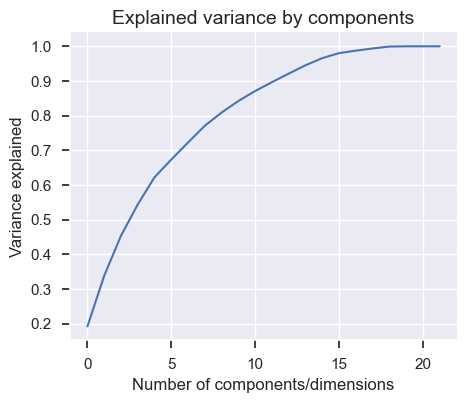

In [240]:
# Plot the cumulative explained variance

# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.title('Explained variance by components', fontsize=plots_Title_fontSize)

## Modeling - K-Means - 16 Components

**Important:**
\
Although there are categorical variables in the dataset, the binary variables, the approach proposed in the project guidelines was implemented (PCA for dimensionality reduction and using K-means for clustering). PCA can be used with binary variables, keeping in mind that the results should be interpreted accordingly. 
K-means uses Euclidean distance and does not have a parameter to change the distance metric. Nevertheless, it can receive a distance matrix as its input. We considered this approach and thought Gower was a good fit as it calculates the distances for mixed data with categorical and numerical attributes. However, the scores for each principal component obtained after PCA result in a linear combination of the features and are numeric and continuous. 
For these reasons, we decided to only use the PCA and K-means(++).

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
\
https://sciencedirect.com/topics/mathematics/principal-component-analysis

In [241]:
# Apply the dimension reduction to the dataset (for 16 components)
pca_reduced = PCA(n_components = 16)
pca_reduced.fit(ds_norm)
X_pca_reduced = pca_reduced.transform(ds_norm) 
print(X_pca_reduced.shape)

(73431, 16)


C:\Users\madal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\madal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\madal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\madal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

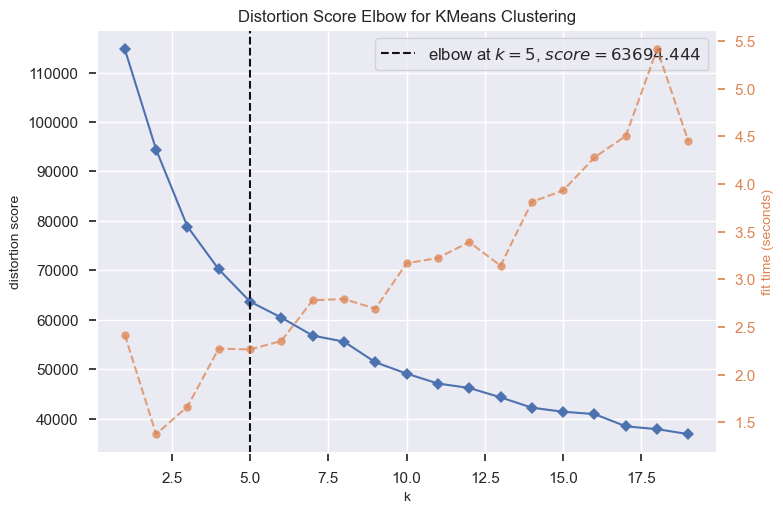

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [242]:
# Apply the Elbow method to select K
km = KMeans(init='k-means++')
visualizer = KElbowVisualizer(km, k=(1,20), random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show()

In [243]:
# Apply the K-Means for K=4
K=5
kmeans = KMeans(n_clusters=K, random_state=123)
allDistances = kmeans.fit_transform(X_pca_reduced)
y_kmeans = kmeans.predict(X_pca_reduced)

C:\Users\madal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


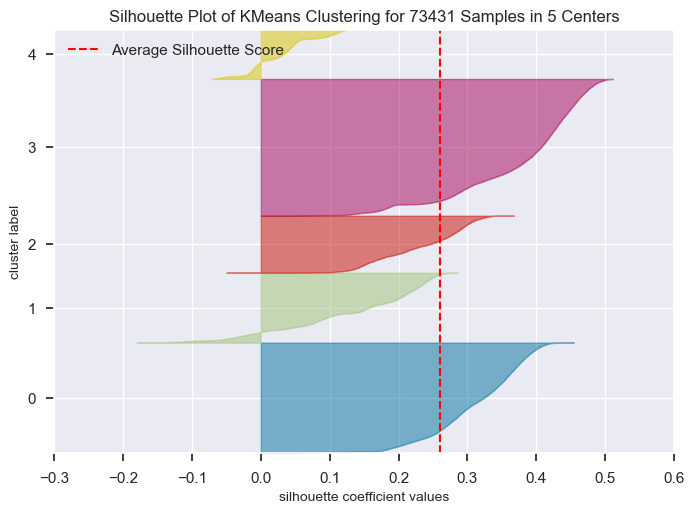

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 73431 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [244]:
# Visualize Silhouette - see https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show()

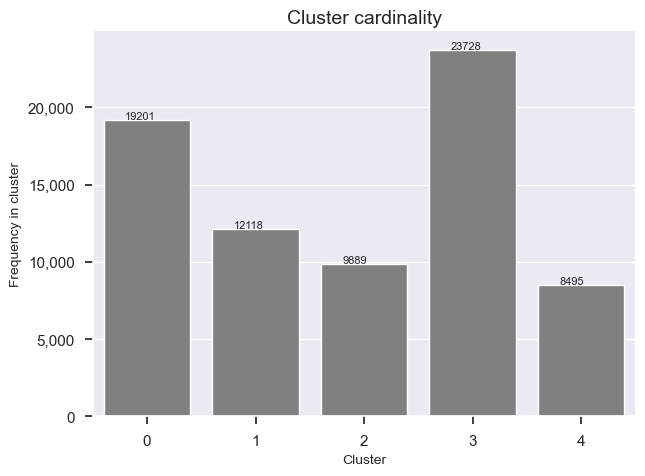

In [245]:
# Plot clusters cardinality 

# Count observations per cluster
freqByCluster = ds_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster cardinality", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=subPlots_label_fontSize)

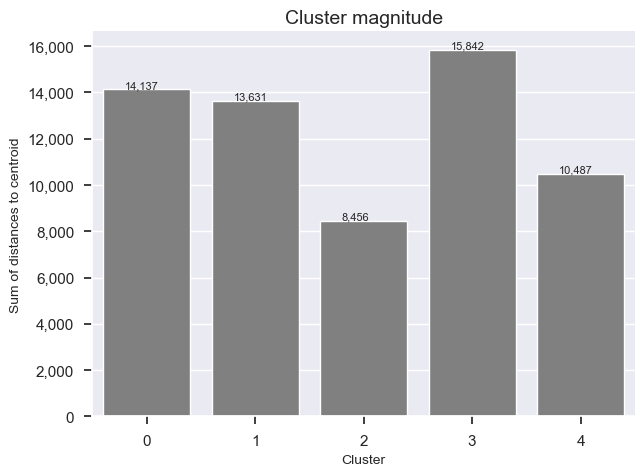

In [246]:
# Plot clusters magnitude

# Compute Magnitude
ds_clean['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = ds_clean['distanceToCentroid'].groupby(y_kmeans).sum()
ds_clean = ds_clean.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=subPlots_label_fontSize)

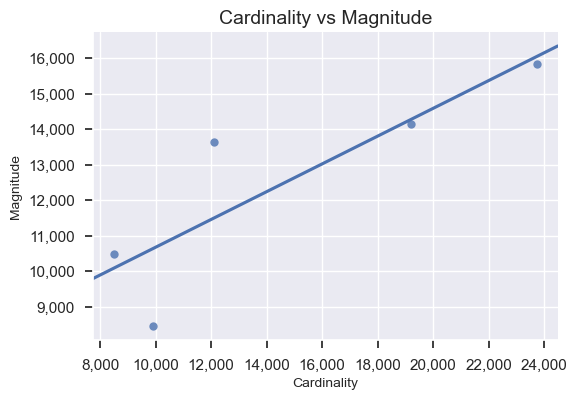

In [247]:
# Plot cardinality vs magnitude

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")
plt.rc('axes', labelsize=subPlots_label_fontSize)

C:\Users\madal\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


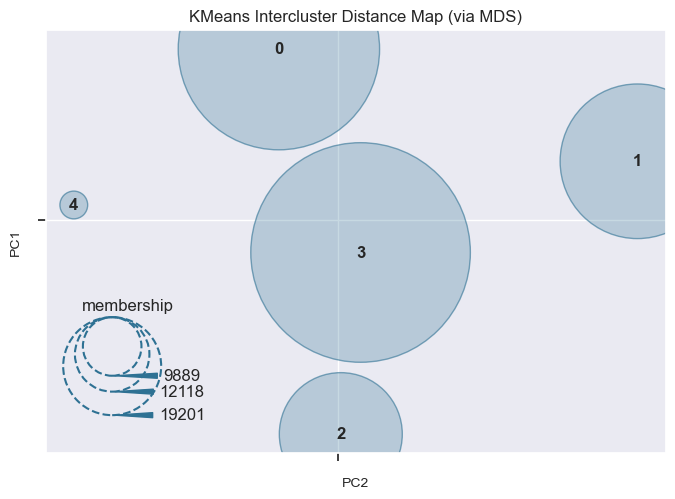

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [248]:
# Visualizing the clusters sizes and distances in 2D
visualizer = InterclusterDistance(kmeans, random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show()

In [249]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=ds_norm.columns)
wheightsDF

,Age,DaysSinceCreation,AverageLeadTime,RoomNights,DistributionChannel_Corporate,DistributionChannel_Travel Agent/Operator,DistributionChannel_Direct,DistributionChannel_GDS Systems,SRHighFloor,SRCrib,SRKingSizeBed,SRTwinBed,SRQuietRoom,NumberOfRequests,TotalRevenue,AverageDailySpend,Foreigner,Cont_AS,Cont_EU,Cont_NA,Cont_Other,Cont_SA
0,-9.975181e-03,1.411020e-03,-7.718984e-02,-5.422969e-02,0.064363,-0.463612,0.384582,0.014667,-4.430707e-02,-4.169422e-03,-6.977481e-01,7.720543e-02,-1.244867e-01,-3.071929e-01,-3.068992e-02,4.283948e-02,-1.039154e-01,-0.011056,0.065202,-0.020644,-0.006552,-0.026950
1,-4.073821e-02,-5.051640e-02,-1.133185e-01,8.700659e-03,0.042824,-0.535933,0.481865,0.011245,3.393553e-02,1.421061e-02,5.484437e-01,-3.432911e-01,1.782682e-02,1.047489e-01,4.673531e-02,5.936632e-02,-8.018473e-02,0.007420,-0.113856,0.064352,0.017335,0.024751
2,5.179500e-02,-1.010657e-01,1.239667e-02,-6.980555e-03,-0.010317,-0.007273,0.017201,0.000389,-3.239241e-04,7.829403e-04,-1.086148e-01,1.958069e-01,-1.396053e-02,3.353647e-02,2.099318e-02,2.016310e-02,2.119821e-01,0.182306,-0.820416,0.381668,0.081668,0.174773
3,1.211454e-02,-1.828795e-01,1.695164e-01,3.140519e-01,-0.037868,-0.157629,0.202780,-0.007283,8.251511e-02,9.120593e-03,8.073117e-03,5.810192e-01,2.495601e-01,3.517630e-01,3.794477e-01,8.610348e-02,2.112960e-01,-0.049149,0.185821,-0.077832,-0.018059,-0.040780
4,-8.104470e-03,9.565570e-02,-1.631537e-01,-4.949439e-01,0.021284,-0.077208,0.056830,-0.000906,5.970519e-02,4.676081e-03,1.119027e-01,5.105409e-01,8.612994e-02,3.013687e-01,-4.531596e-01,-1.015798e-01,-3.435850e-01,0.015544,0.008055,0.007046,-0.015792,-0.014852
5,-1.215655e-01,-5.732815e-01,-2.405270e-01,-9.369529e-02,0.078817,0.082781,-0.179163,0.017564,-1.785150e-02,5.057730e-03,-9.020809e-02,-9.721392e-02,2.797975e-01,1.086254e-03,1.863323e-01,4.655397e-01,-4.378835e-01,0.018434,-0.037746,0.048935,0.000326,-0.029949
6,3.160970e-02,5.805042e-01,-8.394362e-02,2.516588e-01,0.062168,-0.010511,-0.036026,-0.015630,7.670636e-02,1.611617e-03,-1.581190e-01,-1.295855e-01,5.860870e-01,8.722673e-02,1.504727e-01,-9.180337e-02,-3.454606e-01,0.075154,-0.154554,-0.025762,0.028176,0.076986
7,-1.829377e-02,1.062431e-01,-1.813702e-02,3.473910e-01,0.078485,0.015441,-0.078369,-0.015558,-2.326414e-02,3.893118e-03,1.393551e-01,2.508761e-01,-6.064919e-01,-3.275206e-02,2.587673e-01,-6.036664e-02,-5.671700e-01,0.000885,-0.086509,0.030005,0.011260,0.044360
8,-1.617536e-01,4.062075e-01,-3.813253e-01,-1.755003e-01,0.115054,-0.041480,-0.107890,0.034316,3.568619e-02,-7.342315e-03,5.810394e-02,1.150858e-01,-1.912491e-01,1.592127e-02,1.869796e-01,5.529188e-01,3.011340e-01,0.205183,-0.014784,-0.270316,0.032104,0.047812
9,2.614775e-01,2.698860e-01,1.005591e-01,-1.210829e-01,0.071823,-0.031856,-0.057140,0.017172,-3.834164e-02,-2.132681e-02,2.924176e-02,1.696409e-02,-1.672403e-02,-5.475725e-03,1.002649e-01,3.192751e-01,1.011339e-02,-0.349225,0.138229,0.653980,-0.076676,-0.366307


In [250]:
# Study the weights of component 15
comp = abs(wheightsDF.iloc[14])  ## index 14 is component 15
comp = comp.sort_values(ascending=False)
comp

AverageLeadTime                              0.654892
Age                                          0.638465
Cont_SA                                      0.195536
RoomNights                                   0.193828
AverageDailySpend                            0.181731
DaysSinceCreation                            0.131253
Cont_AS                                      0.118483
Foreigner                                    0.097938
DistributionChannel_Corporate                0.059801
Cont_EU                                      0.051945
DistributionChannel_Travel Agent/Operator    0.051637
Cont_Other                                   0.041110
SRHighFloor                                  0.028791
SRCrib                                       0.024779
TotalRevenue                                 0.020990
SRTwinBed                                    0.019758
SRQuietRoom                                  0.016587
Cont_NA                                      0.016002
DistributionChannel_Direct  

In [251]:
# Reverse the loragithmic transformations applied
ds_beforeNorm[columns_to_transform] = np.expm1(ds_beforeNorm[columns_to_transform].astype(float))

In [252]:
# Check the mean values of each cluster for top 30 relevant features
top_features = comp[:30].index
clustersMeanDF = pd.DataFrame(ds_beforeNorm[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF.transpose().style.background_gradient(axis=1)

,0,1,2,3,4
AverageLeadTime,89.798317,58.542964,120.552601,92.316238,81.311026
Age,47.228009,46.670573,50.948781,48.586649,50.865686
Cont_SA,0.000000,0.026242,0.037618,0.000000,0.252266
RoomNights,3.312640,3.016752,3.005562,3.191715,3.037669
AverageDailySpend,80.774178,93.546047,78.821772,81.039679,82.493349
DaysSinceCreation,702.225952,644.578613,646.504517,724.033142,642.644958
Cont_AS,0.000000,0.024344,0.053595,0.000000,0.239906
Foreigner,0.908911,0.797656,0.942967,0.885494,1.000000
DistributionChannel_Corporate,0.009322,0.130467,0.013550,0.000000,0.033196
Cont_EU,1.000000,0.852946,0.821721,1.000000,0.000000


**Important:**
The K-medoids algorithm was also tested to cluster the data points, as it is more robust to noise and is suitable for categorical data. However, due to the fact that it needs to compute a distance matrix for every pair of points in the data set, meaning it is very computationally expensive, it generated a memory error and so it was not used to reach the final solution.